# バグ発見数のcpNumとcpNum_rangeに対する依存関係をヒートマップで分析

このノートブックは、cpNumとcpNum_rangeの各組み合わせでのバグ発見数を分析し、ヒートマップで可視化します。

## 分析内容
1. cpNumとcpNum_rangeの各組み合わせでのバグ発見数の集計
2. チェックポイント別および全体統計のヒートマップ作成
3. バグ発見、null、timeout別の詳細分析
4. 統計的サマリーの出力


In [23]:

# 必要なライブラリのインポート
import os
import csv
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import matplotlib.font_manager as fm

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 可能であれば日本語フォントを設定
try:
    if os.name == 'posix':  # Mac/Linux
        japanese_fonts = ['Hiragino Sans', 'Hiragino Kaku Gothic Pro', 'Yu Gothic', 'Meiryo']
        for font in japanese_fonts:
            try:
                plt.rcParams['font.family'] = font
                break
            except:
                continue
except:
    pass

# 図のサイズ設定
plt.rcParams['figure.figsize'] = (12, 8)
print("ライブラリのインポートが完了しました")


ライブラリのインポートが完了しました


In [24]:
# 分析用のクラス宣言

class BugHeatmapAnalyzer:
    """バグ発見数のヒートマップ分析クラス"""
    
    
    def __init__(self, cpNum_params):
        """
        初期化
        """
        self.logs_path = 'Logs'
        
        # パラメータ設定
        self.cpnum_values = cpNum_params
        self.cpnum_range_values = [1, 50, 99]
        self.cpnum_dir_values = [1, 2, 3, 4]
        self.checkpoints = list(range(1, 11))  # checkpoint 1-10
        self.tree_values = [0, 500, 1000]  # treeパラメータの値
        
        # データを格納する辞書（tree値別に分けて保存）
        self.bug_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))
        self.null_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))
        self.timeout_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))
        
    def parse_directory_name(self, dir_name):
        """
        ディレクトリ名をパースしてパラメータを抽出
        
        Args:
            dir_name (str): ディレクトリ名（カンマ区切りのパラメータ文字列）
            
        Returns:
            dict: パラメータ辞書
        """
        params = dir_name.split(',')
        if len(params) < 30:
            return None
            
        try:
            # パラメータインデックスに基づいて値を抽出
            checkpoint_idx = None
            cpnum = None
            cpnum_range = None
            # cpnum_dir = int(params[29])  # 最後のパラメータがcpnum_dir
            cpnum_dir = None  
            
            # checkpointインデックスを特定（0以外の値があるインデックス）
            for i in range(10):
                if int(params[i]) != 0:
                    checkpoint_idx = i + 1
                    cpnum = int(params[i])
                    break
                    
            # cpnum_rangeを特定（10-19の範囲で0以外の値）
            for i in range(10, 20):
                if int(params[i]) != 0:
                    cpnum_range = int(params[i])
                    break
            
            
            if checkpoint_idx is None or cpnum is None or cpnum_range is None:
                return None
                
            return {
                'checkpoint': checkpoint_idx,
                'cpnum': cpnum,
                'cpnum_range': cpnum_range,
                'cpnum_dir': cpnum_dir
            }
        except (ValueError, IndexError):
            return None
    
    def load_detected_bugs_data(self, file_path):
        """
        detected_bugs.csvファイルからデータを読み込み
        
        Args:
            file_path (str): CSVファイルのパス
            
        Returns:
            dict: バグ発見数、null数、timeout数を含む辞書
        """
        bug_count = 0
        null_count = 0
        timeout_count = 0
        
        try:
            with open(file_path, 'r', encoding='utf-8') as csvfile:
                reader = csv.reader(csvfile)
                for row in reader:
                    if row == ["null"]:
                        null_count += 1
                    elif row == ["timeout"]:
                        timeout_count += 1
                    elif row:  # 空行でない場合
                        bug_count += 1
                        
        except FileNotFoundError:
            print(f"ファイルが見つかりません: {file_path}")
            return None
        except Exception as e:
            print(f"ファイル読み込みエラー: {file_path}, エラー: {e}")
            return None
            
        return {
            'bugs': bug_count,
            'null': null_count,
            'timeout': timeout_count
        }
    
    def collect_data(self):
        """
        全てのログディレクトリからデータを収集（tree値別に処理）
        """
        print("データ収集を開始しています...")
        
        if not os.path.exists(self.logs_path):
            raise FileNotFoundError(f"ログディレクトリが見つかりません: {self.logs_path}")
        
        total_processed = 0
        total_directories = 0
        
        # 各tree値に対して処理
        for tree in self.tree_values:
            tree_path = os.path.join(self.logs_path, f"tree={tree}")
            
            if not os.path.exists(tree_path):
                print(f"警告: {tree_path} が見つかりません。スキップします。")
                continue
            
            print(f"  tree={tree} のディレクトリを処理中...")
            processed_count = 0
            directories_in_tree = len([d for d in os.listdir(tree_path) 
                                     if os.path.isdir(os.path.join(tree_path, d))])
            total_directories += directories_in_tree
            
            for dir_name in os.listdir(tree_path):
                dir_path = os.path.join(tree_path, dir_name)
                
                if not os.path.isdir(dir_path):
                    continue
                    
                # ディレクトリ名をパース
                params = self.parse_directory_name(dir_name)
                if params is None:
                    continue
                    
                # detected_bugs.csvファイルのパス
                csv_path = os.path.join(dir_path, 'detected_bugs.csv')
                
                # データ読み込み
                data = self.load_detected_bugs_data(csv_path)
                if data is None:
                    continue
                    
                # データを格納（tree値別に保存）
                checkpoint = params['checkpoint']
                cpnum = params['cpnum']
                cpnum_range = params['cpnum_range']
                
                self.bug_data[tree][checkpoint][cpnum][cpnum_range].append(data['bugs'])
                self.null_data[tree][checkpoint][cpnum][cpnum_range].append(data['null'])
                self.timeout_data[tree][checkpoint][cpnum][cpnum_range].append(data['timeout'])
                
                processed_count += 1
                total_processed += 1
            
            print(f"  tree={tree}: {processed_count}/{directories_in_tree} ディレクトリを処理しました")
            
        print(f"データ収集完了: 合計 {total_processed}/{total_directories} ディレクトリを処理しました")
    
    def create_heatmap_matrix(self, data_dict, tree, aggregation_func=np.mean):
        """
        ヒートマップ用の行列を作成
        
        Args:
            data_dict (dict): データ辞書
            tree (int): tree値
            aggregation_func (function): 集約関数（平均、合計など）
            
        Returns:
            numpy.ndarray: ヒートマップ用行列
        """
        matrix = np.zeros((len(self.cpnum_values), len(self.cpnum_range_values)))
        
        for i, cpnum in enumerate(self.cpnum_values):
            for j, cpnum_range in enumerate(self.cpnum_range_values):
                values = []
                for checkpoint in self.checkpoints:
                    if (tree in data_dict and 
                        checkpoint in data_dict[tree] and 
                        cpnum in data_dict[tree][checkpoint] and 
                        cpnum_range in data_dict[tree][checkpoint][cpnum]):
                        values.extend(data_dict[tree][checkpoint][cpnum][cpnum_range])
                
                if values:
                    matrix[i, j] = aggregation_func(values)
                else:
                    matrix[i, j] = np.nan
                    
        return matrix
    
    def plot_heatmap(self, matrix, title, filename, data_type="バグ発見数", vmin=None, vmax=None, cmap='YlOrRd'):
        """
        ヒートマップをプロット
        
        Args:
            matrix (numpy.ndarray): ヒートマップ用行列
            title (str): グラフタイトル
            filename (str): 保存ファイル名
            data_type (str): データタイプ（表示用）
            vmin (float): カラーマップの最小値
            vmax (float): カラーマップの最大値
        """
        plt.figure(figsize=(10, 8))
        
        # データフレームに変換
        df = pd.DataFrame(
            matrix,
            index=[x for x in self.cpnum_values],
            columns=[x for x in self.cpnum_range_values]
        )
        
        # ヒートマップ作成
        mask = np.isnan(matrix)
        sns.heatmap(
            df, 
            annot=True, 
            fmt='.2f', 
            cmap=cmap,
            cbar_kws={'label': data_type},
            linewidths=0.5,
            square=True
        )
        
        # sns.heatmap(
        #     heatmap_data,
        #     annot=True,
        #     fmt='.2f',
        #     cmap=cmap,
        #     cbar_kws={'label': data_type},
        #     linewidths=0.5,
        #     square=True
        # )
        
        plt.title(title, fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('cpNum_range', fontsize=12)
        plt.ylabel('cpNum', fontsize=12)
        plt.tight_layout()
        
        plt.show()
        
        return df
    
    def plot_comprehensive_heatmaps(self):
        """
        包括的なヒートマップ分析を実行（tree値別）
        """
        print("ヒートマップ分析を開始しています...")
        
        all_results = {}
        
        # 各tree値に対してヒートマップを生成
        for tree in self.tree_values:
            print(f"\n{'='*60}")
            print(f"=== tree={tree} のヒートマップ分析 ===")
            print(f"{'='*60}")
            
            # 1. tree値別のヒートマップ（平均値）
            print(f"\n--- tree={tree}: 平均値ヒートマップ ---")
            
            # バグ発見数
            bug_matrix_mean = self.create_heatmap_matrix(self.bug_data, tree, np.mean)
            bug_df_mean = self.plot_heatmap(
                bug_matrix_mean, 
                f"バグ発見数の平均値 (tree={tree}, cpNum vs cpNum_range)",
                f"tree{tree}_bug_heatmap_mean.png",
                "平均バグ発見数",
                cmap='YlOrRd'
            )
            
            # null発生数
            null_matrix_mean = self.create_heatmap_matrix(self.null_data, tree, np.mean)
            null_df_mean = self.plot_heatmap(
                null_matrix_mean,
                f"Null発生数の平均値 (tree={tree}, cpNum vs cpNum_range)", 
                f"tree{tree}_null_heatmap_mean.png",
                "平均Null発生数",
                cmap='Blues'
            )
            
            # timeout発生数
            timeout_matrix_mean = self.create_heatmap_matrix(self.timeout_data, tree, np.mean)
            timeout_df_mean = self.plot_heatmap(
                timeout_matrix_mean,
                f"Timeout発生数の平均値 (tree={tree}, cpNum vs cpNum_range)",
                f"tree{tree}_timeout_heatmap_mean.png", 
                "平均Timeout発生数",
                cmap='Reds'
            )
            
            # 2. tree値別のヒートマップ（合計値）
            print(f"\n--- tree={tree}: 合計値ヒートマップ ---")
            
            bug_matrix_sum = self.create_heatmap_matrix(self.bug_data, tree, np.sum)
            bug_df_sum = self.plot_heatmap(
                bug_matrix_sum,
                f"バグ発見数の合計値 (tree={tree}, cpNum vs cpNum_range)",
                f"tree{tree}_bug_heatmap_sum.png",
                "合計バグ発見数",
                cmap='YlOrRd'
            )
            
            null_matrix_sum = self.create_heatmap_matrix(self.null_data, tree, np.sum)
            null_df_sum = self.plot_heatmap(
                null_matrix_sum,
                f"Null発生数の合計値 (tree={tree}, cpNum vs cpNum_range)",
                f"tree{tree}_null_heatmap_sum.png",
                "合計Null発生数",
                cmap='Blues'
            )
            
            timeout_matrix_sum = self.create_heatmap_matrix(self.timeout_data, tree, np.sum)
            timeout_df_sum = self.plot_heatmap(
                timeout_matrix_sum,
                f"Timeout発生数の合計値 (tree={tree}, cpNum vs cpNum_range)",
                f"tree{tree}_timeout_heatmap_sum.png",
                "合計Timeout発生数",
                cmap='Reds'
            )
            
            # 結果を保存
            all_results[tree] = {
                'bug_mean': bug_df_mean,
                'bug_sum': bug_df_sum,
                'null_mean': null_df_mean,
                'null_sum': null_df_sum,
                'timeout_mean': timeout_df_mean,
                'timeout_sum': timeout_df_sum
            }
        
        return all_results
    
    def generate_statistical_summary(self):
        """
        統計的サマリーを生成（tree値別）
        """
        print("\n=== 統計的サマリー ===")
        
        # 各tree値に対して統計を生成
        for tree in self.tree_values:
            print(f"\n{'='*60}")
            print(f"=== tree={tree} の統計情報 ===")
            print(f"{'='*60}")
            
            # tree値別の統計情報
            total_bugs = 0
            total_nulls = 0
            total_timeouts = 0
            total_experiments = 0
            
            for checkpoint in self.checkpoints:
                for cpnum in self.cpnum_values:
                    for cpnum_range in self.cpnum_range_values:
                        if (tree in self.bug_data and 
                            checkpoint in self.bug_data[tree] and 
                            cpnum in self.bug_data[tree][checkpoint] and 
                            cpnum_range in self.bug_data[tree][checkpoint][cpnum]):
                            
                            bugs = self.bug_data[tree][checkpoint][cpnum][cpnum_range]
                            nulls = self.null_data[tree][checkpoint][cpnum][cpnum_range]
                            timeouts = self.timeout_data[tree][checkpoint][cpnum][cpnum_range]
                            
                            total_bugs += sum(bugs)
                            total_nulls += sum(nulls)
                            total_timeouts += sum(timeouts)
                            total_experiments += len(bugs)
            
            print(f"\ntree={tree} の総実験数: {total_experiments}")
            print(f"tree={tree} の総バグ発見数: {total_bugs}")
            print(f"tree={tree} の総Null発生数: {total_nulls}")
            print(f"tree={tree} の総Timeout発生数: {total_timeouts}")
            if total_experiments > 0:
                print(f"tree={tree} の平均バグ発見率: {total_bugs/total_experiments:.3f}")
                print(f"tree={tree} の平均Null発生率: {total_nulls/total_experiments:.3f}")
                print(f"tree={tree} の平均Timeout発生率: {total_timeouts/total_experiments:.3f}")
            
            # cpNum別統計
            print(f"\n--- tree={tree}: cpNum別統計 ---")
            for cpnum in self.cpnum_values:
                bugs_for_cpnum = []
                for checkpoint in self.checkpoints:
                    for cpnum_range in self.cpnum_range_values:
                        if (tree in self.bug_data and 
                            checkpoint in self.bug_data[tree] and 
                            cpnum in self.bug_data[tree][checkpoint] and 
                            cpnum_range in self.bug_data[tree][checkpoint][cpnum]):
                            bugs_for_cpnum.extend(self.bug_data[tree][checkpoint][cpnum][cpnum_range])
                
                if bugs_for_cpnum:
                    print(f"  cpNum={cpnum}: 平均バグ発見数={np.mean(bugs_for_cpnum):.3f}, "
                          f"合計={np.sum(bugs_for_cpnum)}, 実験数={len(bugs_for_cpnum)}")
            
            # cpNum_range別統計
            print(f"\n--- tree={tree}: cpNum_range別統計 ---")
            for cpnum_range in self.cpnum_range_values:
                bugs_for_range = []
                for checkpoint in self.checkpoints:
                    for cpnum in self.cpnum_values:
                        if (tree in self.bug_data and 
                            checkpoint in self.bug_data[tree] and 
                            cpnum in self.bug_data[tree][checkpoint] and 
                            cpnum_range in self.bug_data[tree][checkpoint][cpnum]):
                            bugs_for_range.extend(self.bug_data[tree][checkpoint][cpnum][cpnum_range])
                
                if bugs_for_range:
                    print(f"  cpNum_range={cpnum_range}: 平均バグ発見数={np.mean(bugs_for_range):.3f}, "
                          f"合計={np.sum(bugs_for_range)}, 実験数={len(bugs_for_range)}")


def main(cpNum_params):
    """メイン実行関数"""
    
    try:
        # 分析器を初期化
        analyzer = BugHeatmapAnalyzer(cpNum_params)
        
        # データ収集
        analyzer.collect_data()
        
        # ヒートマップ作成
        results = analyzer.plot_comprehensive_heatmaps()
        
        # 統計サマリー生成
        analyzer.generate_statistical_summary()
        
        print("\n=== 分析完了 ===")
        print("\n生成されたファイル（tree値別）:")
        for tree in analyzer.tree_values:
            print(f"\n--- tree={tree} ---")
            print(f"- tree{tree}_bug_heatmap_mean.png: バグ発見数平均値ヒートマップ")
            print(f"- tree{tree}_bug_heatmap_sum.png: バグ発見数合計値ヒートマップ")
            print(f"- tree{tree}_null_heatmap_mean.png: Null発生数平均値ヒートマップ")
            print(f"- tree{tree}_null_heatmap_sum.png: Null発生数合計値ヒートマップ")
            print(f"- tree{tree}_timeout_heatmap_mean.png: Timeout発生数平均値ヒートマップ")
            print(f"- tree{tree}_timeout_heatmap_sum.png: Timeout発生数合計値ヒートマップ")
        
        
        
    except Exception as e:
        print(f"エラーが発生しました: {e}")
        sys.exit(1)


# cpNum = [1, 50, 99]の時

データ収集を開始しています...
  tree=0 のディレクトリを処理中...
  tree=0: 720/720 ディレクトリを処理しました
  tree=500 のディレクトリを処理中...
  tree=500: 720/720 ディレクトリを処理しました
  tree=1000 のディレクトリを処理中...
  tree=1000: 720/720 ディレクトリを処理しました
データ収集完了: 合計 2160/2160 ディレクトリを処理しました
ヒートマップ分析を開始しています...

=== tree=0 のヒートマップ分析 ===

--- tree=0: 平均値ヒートマップ ---


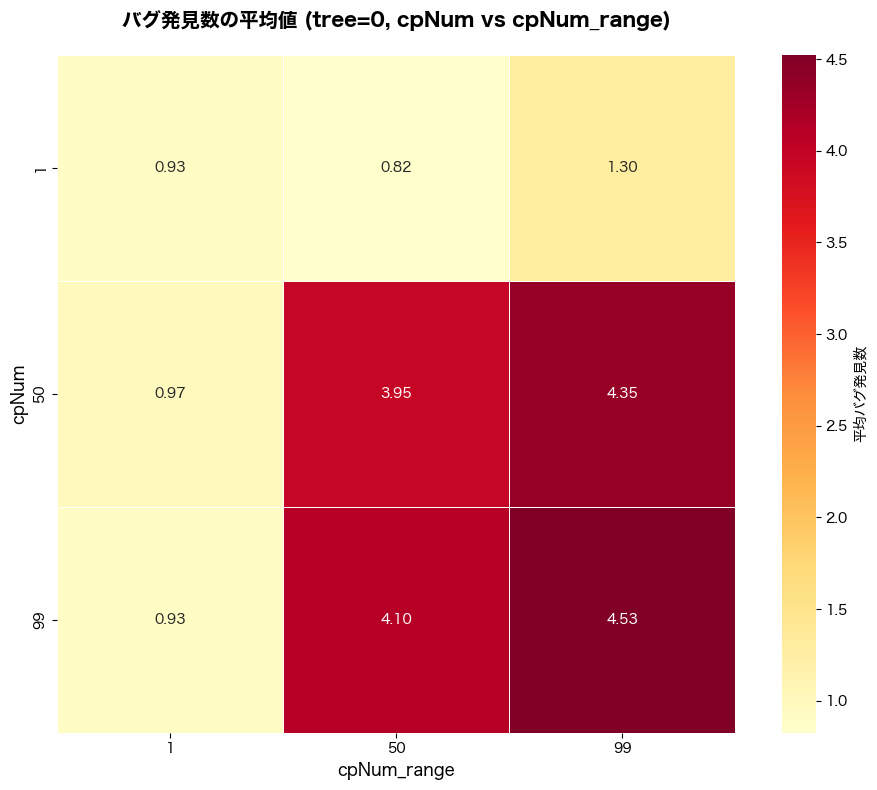

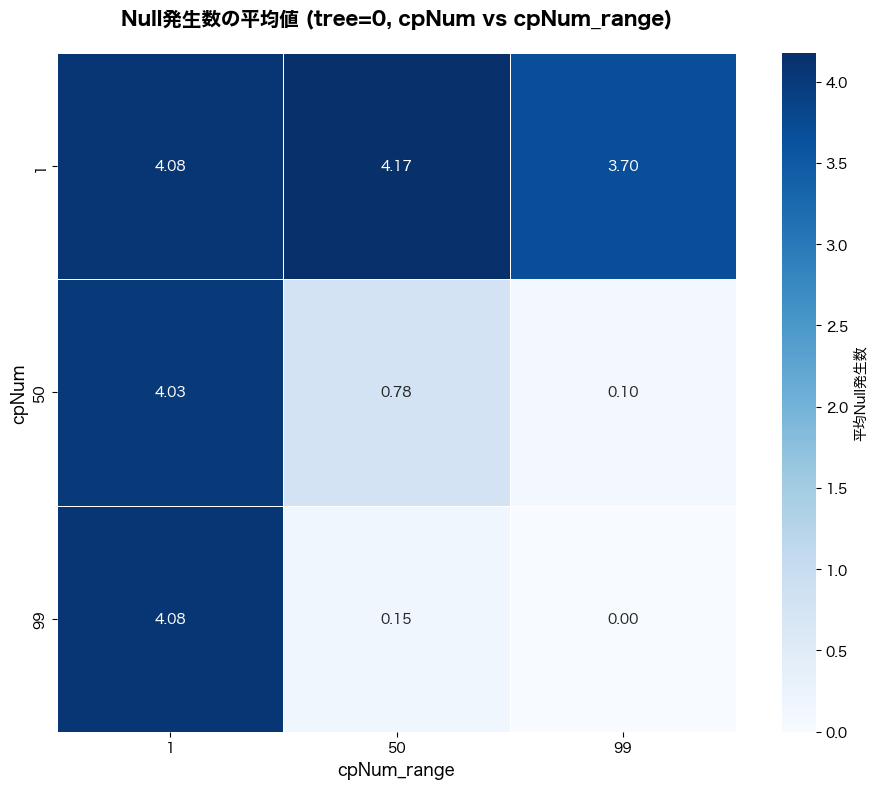

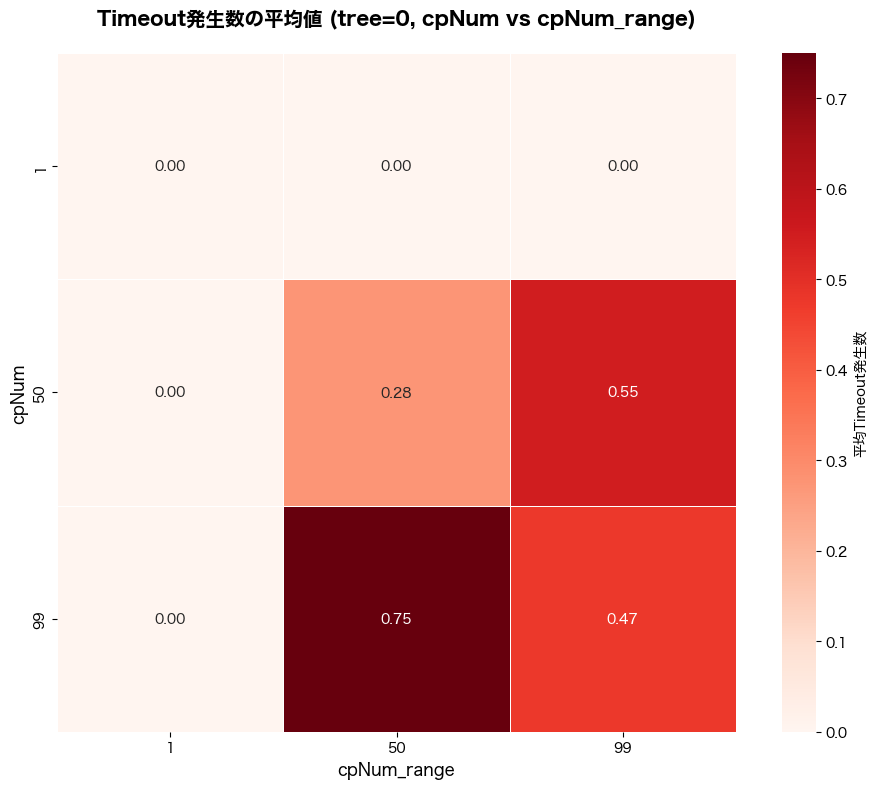


--- tree=0: 合計値ヒートマップ ---


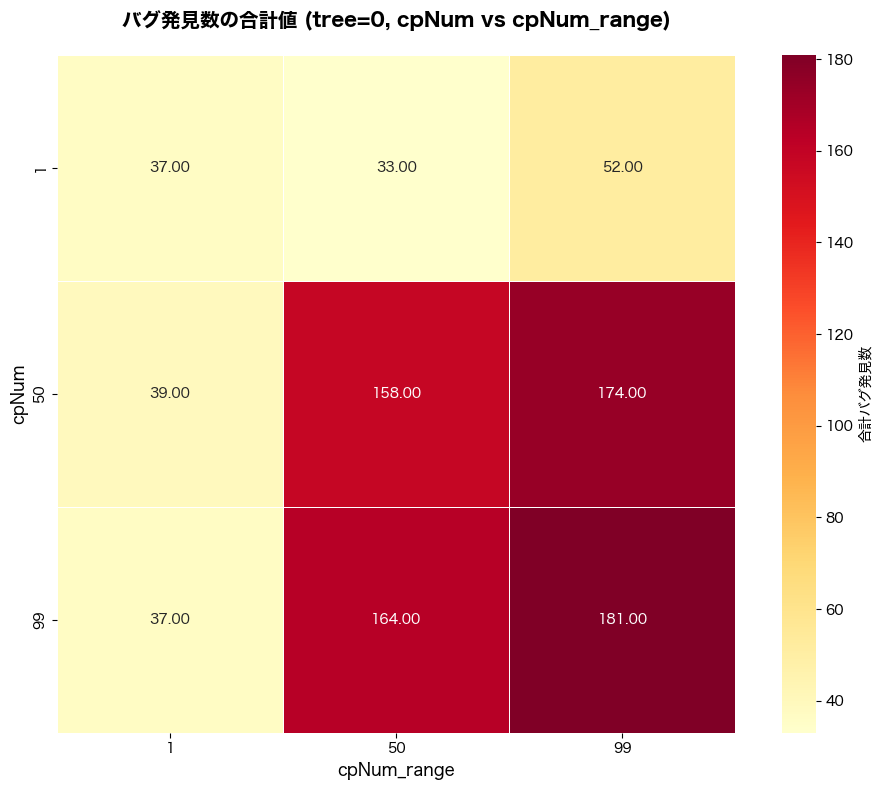

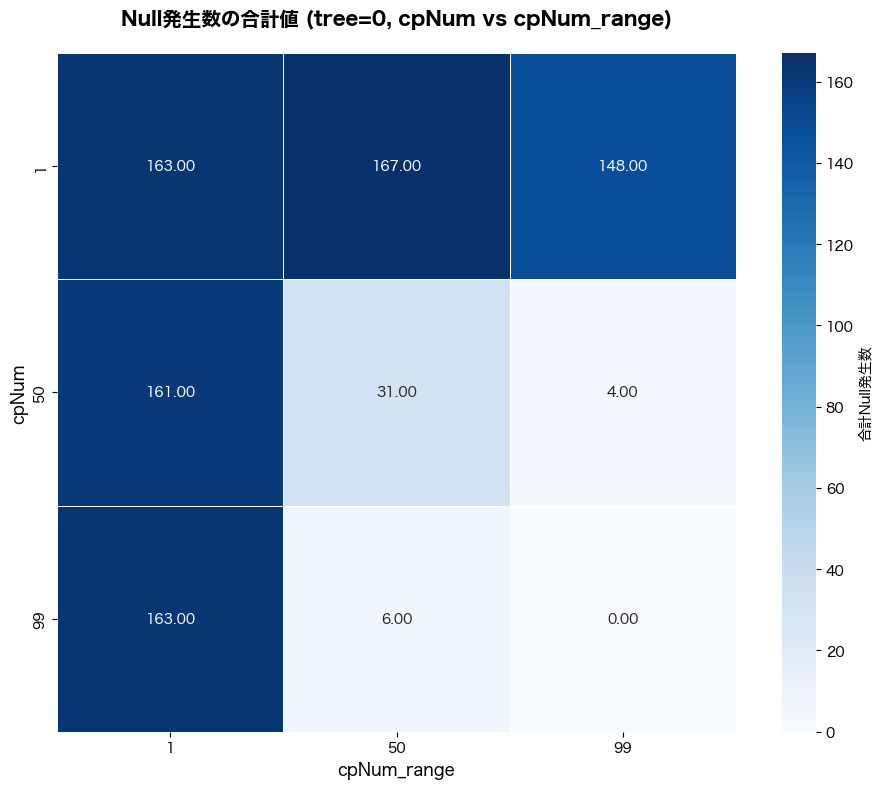

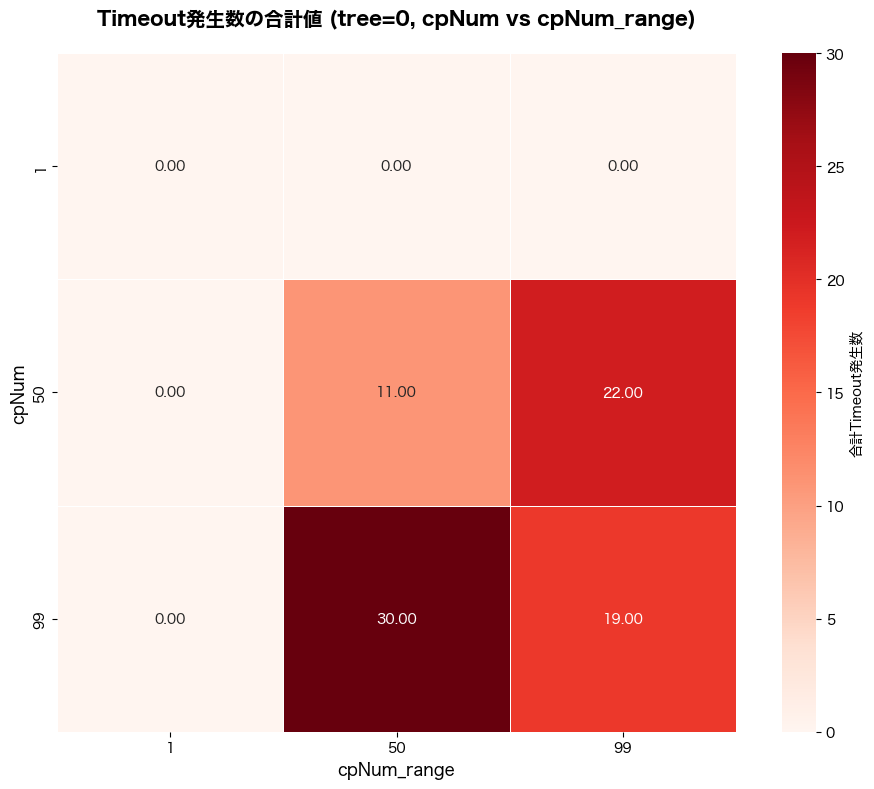


=== tree=500 のヒートマップ分析 ===

--- tree=500: 平均値ヒートマップ ---


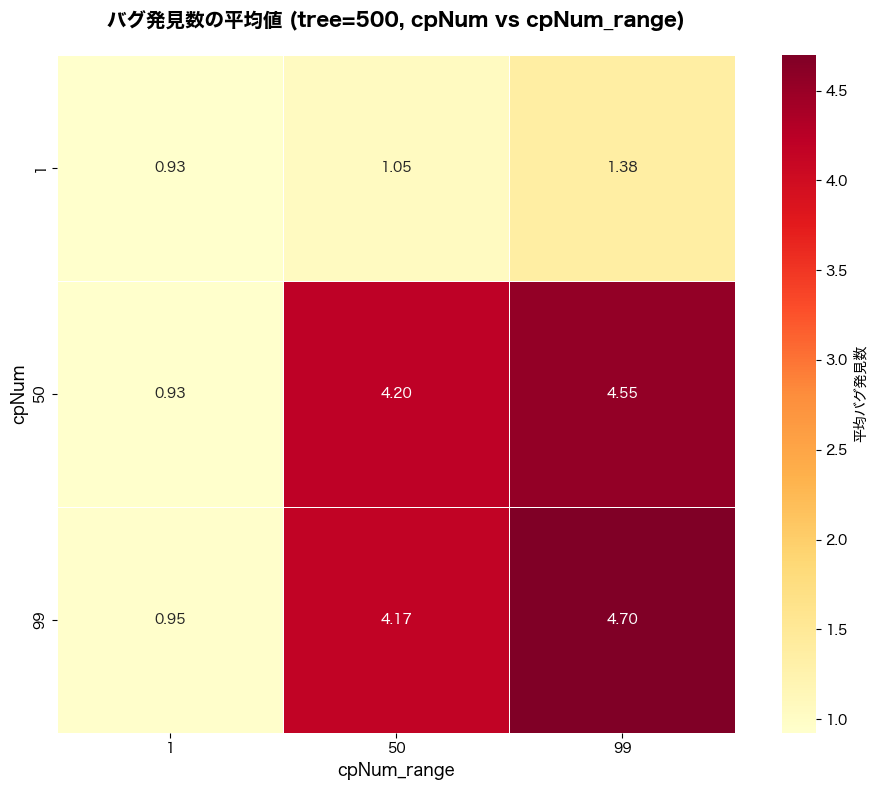

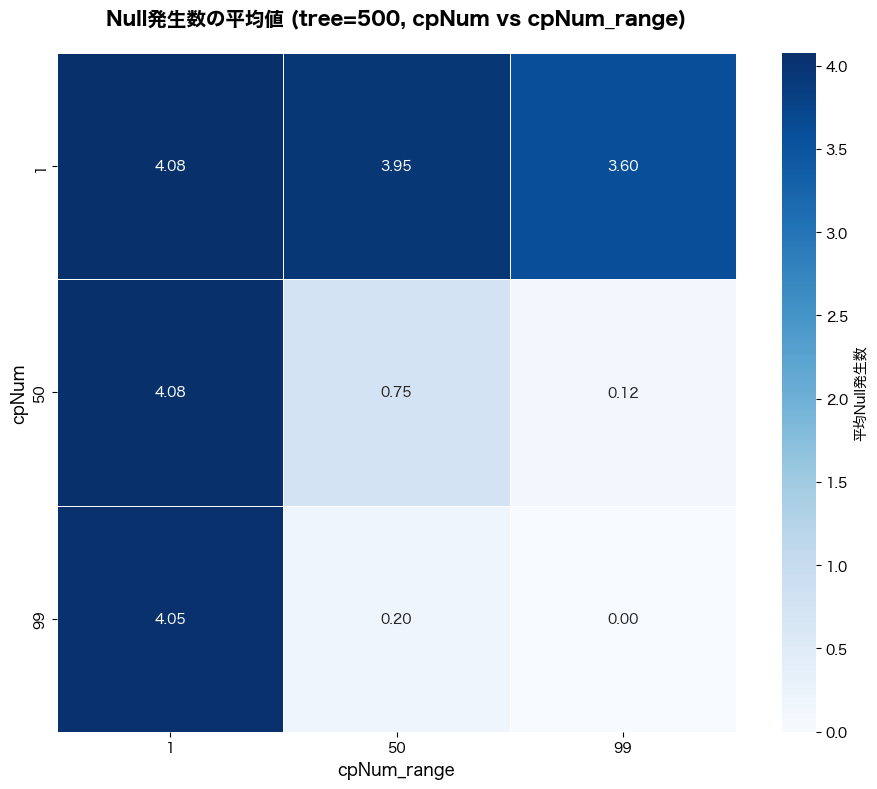

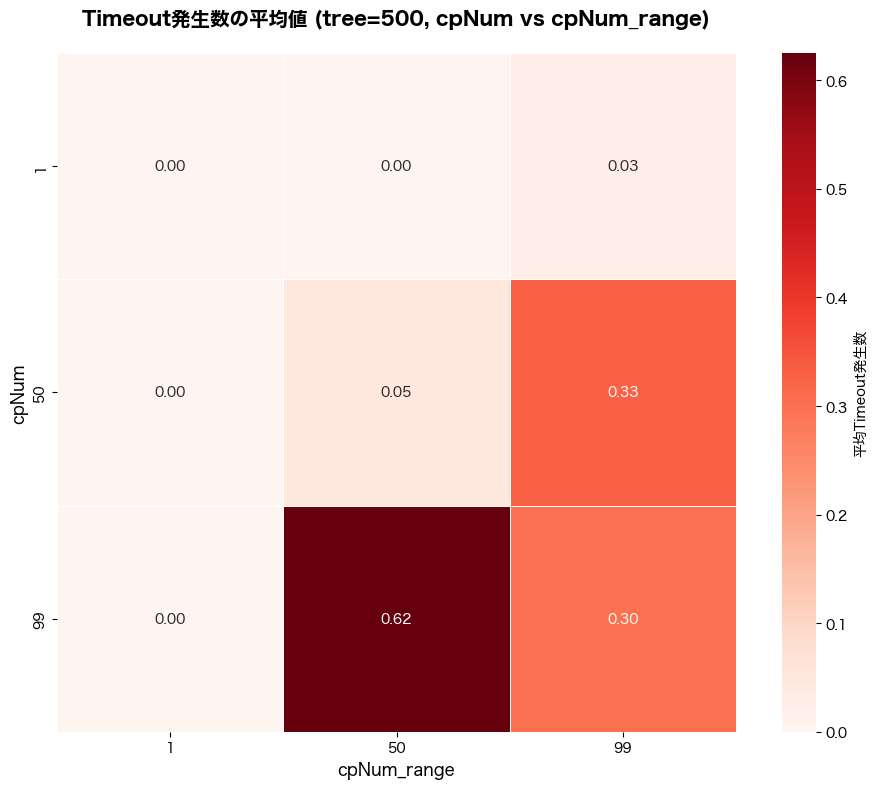


--- tree=500: 合計値ヒートマップ ---


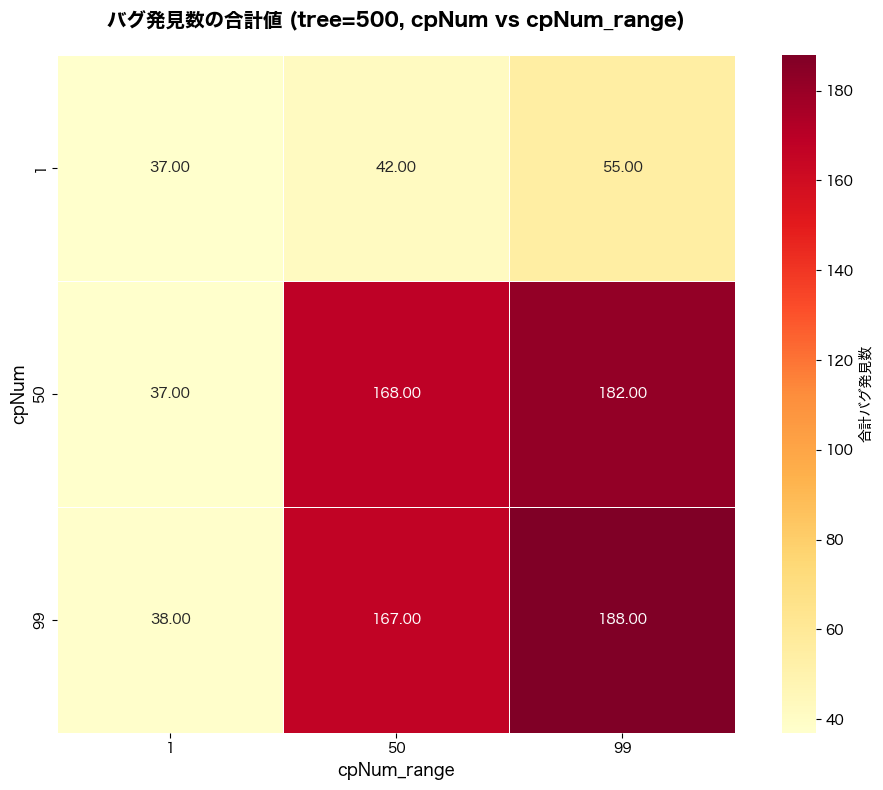

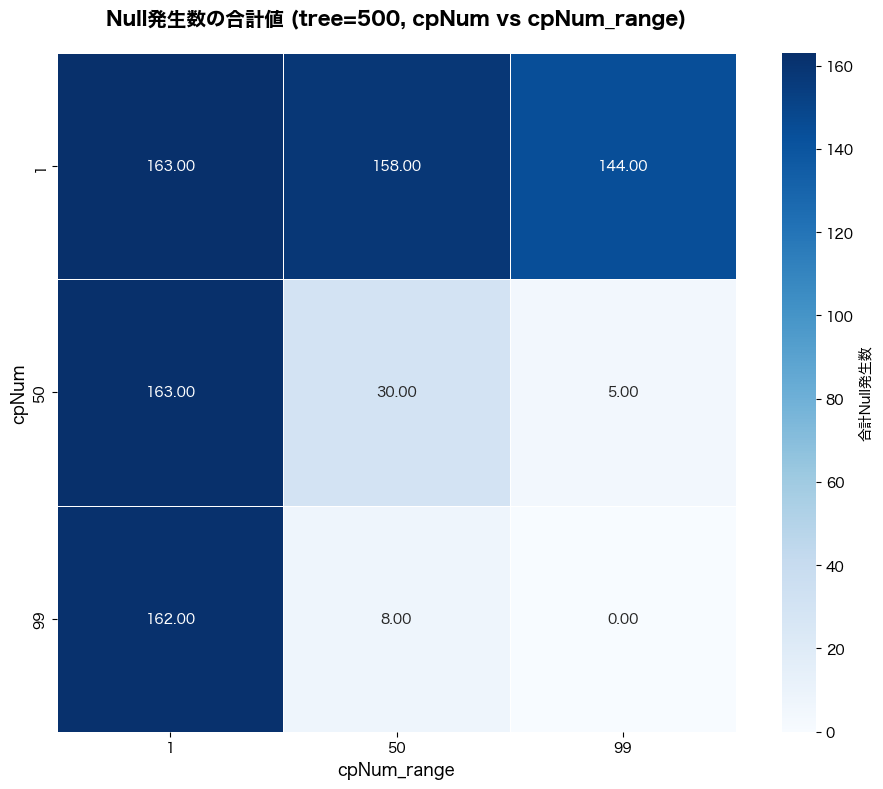

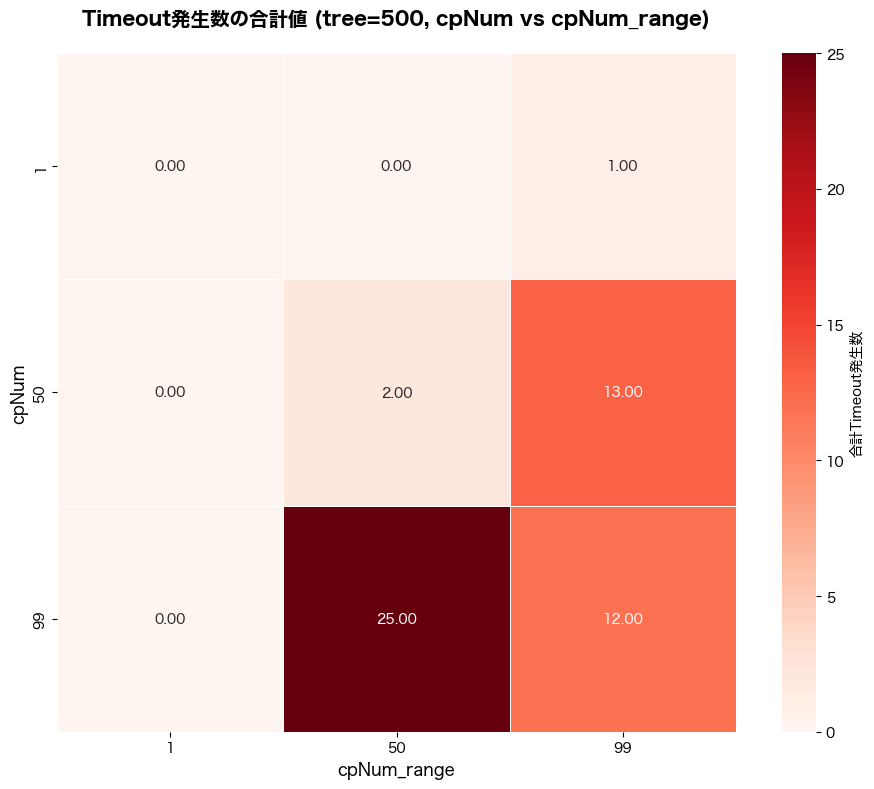


=== tree=1000 のヒートマップ分析 ===

--- tree=1000: 平均値ヒートマップ ---


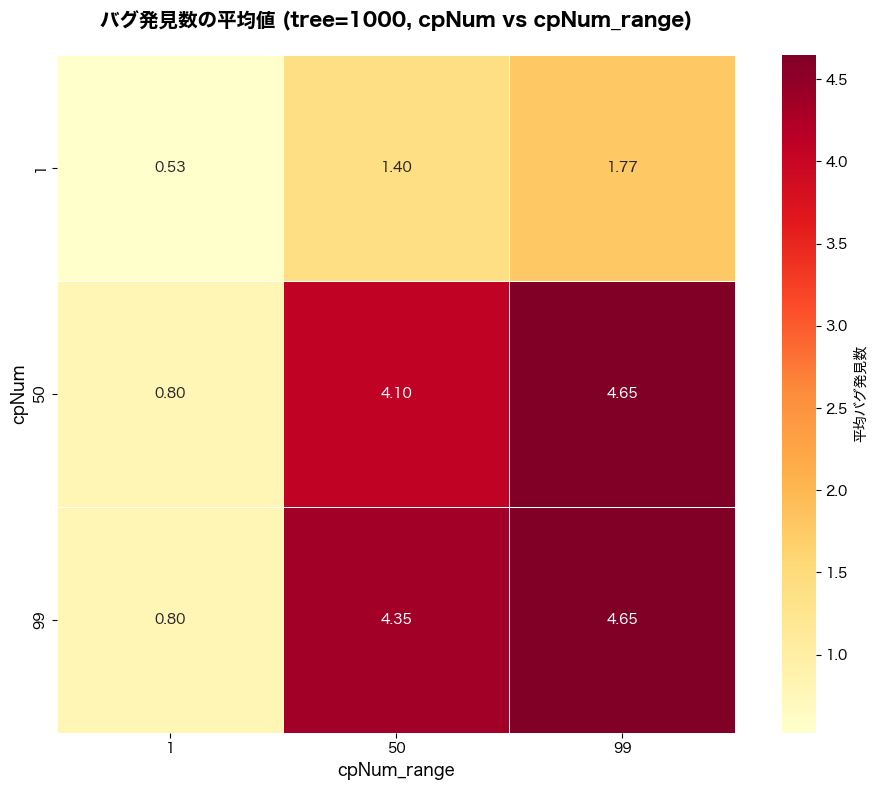

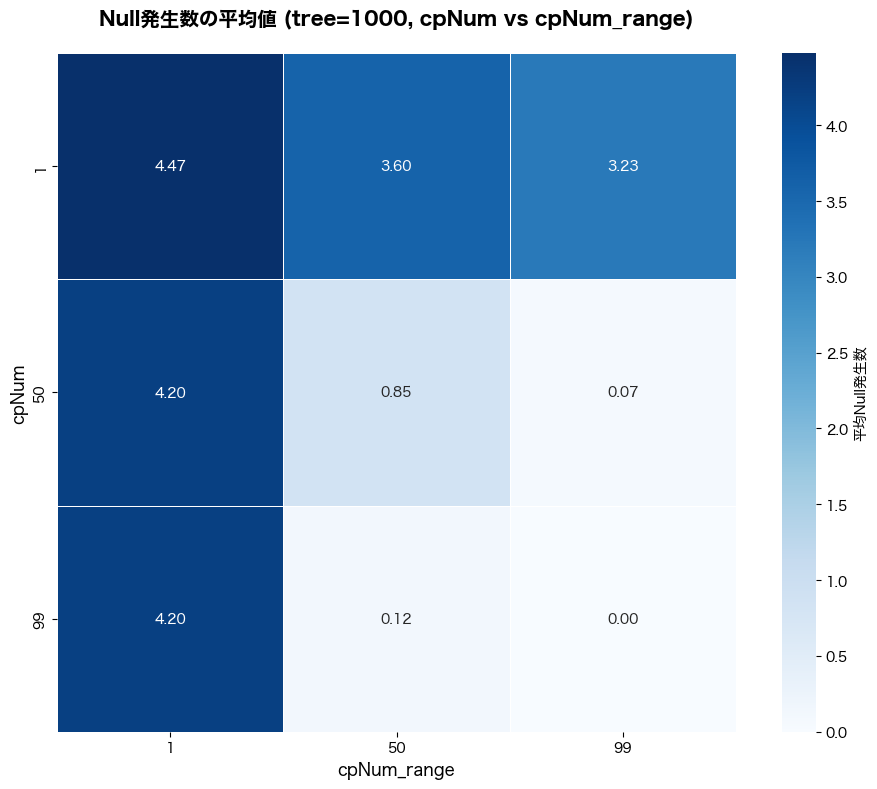

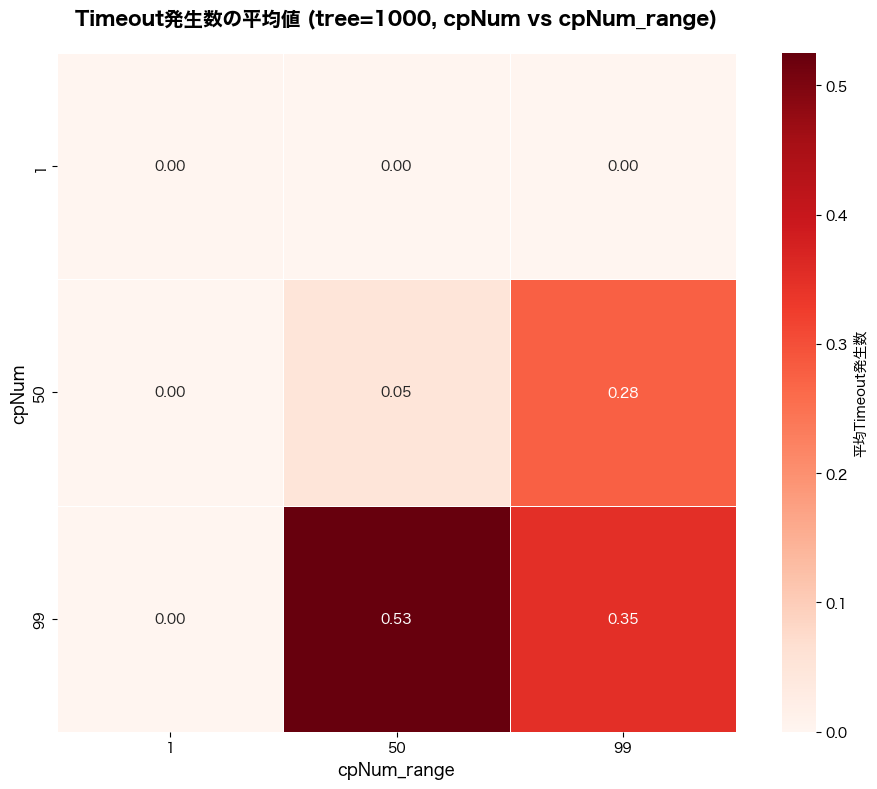


--- tree=1000: 合計値ヒートマップ ---


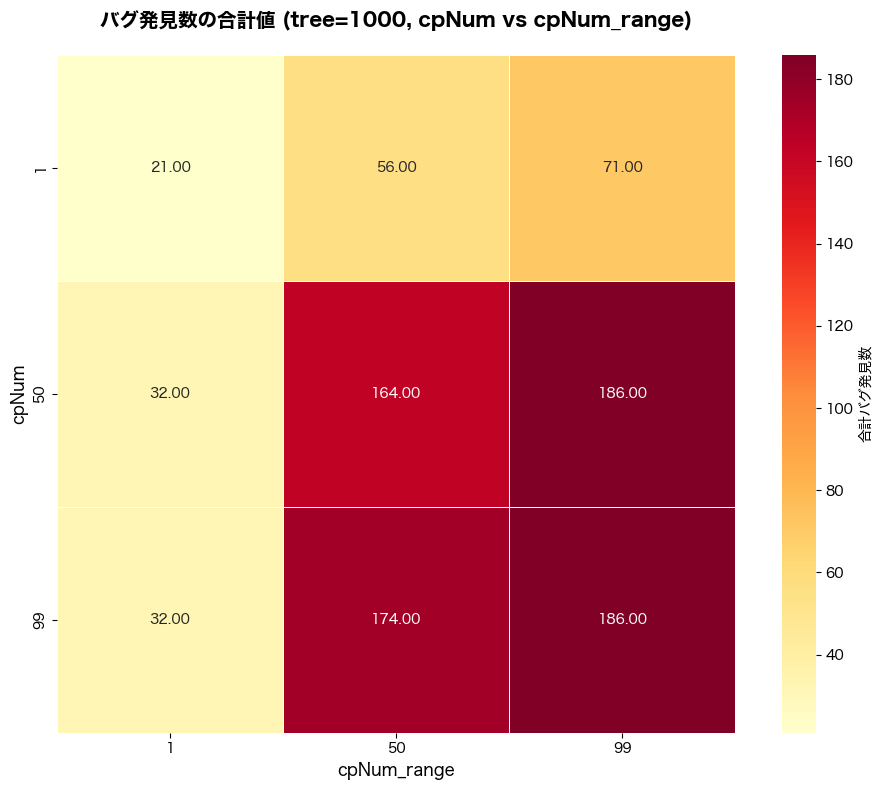

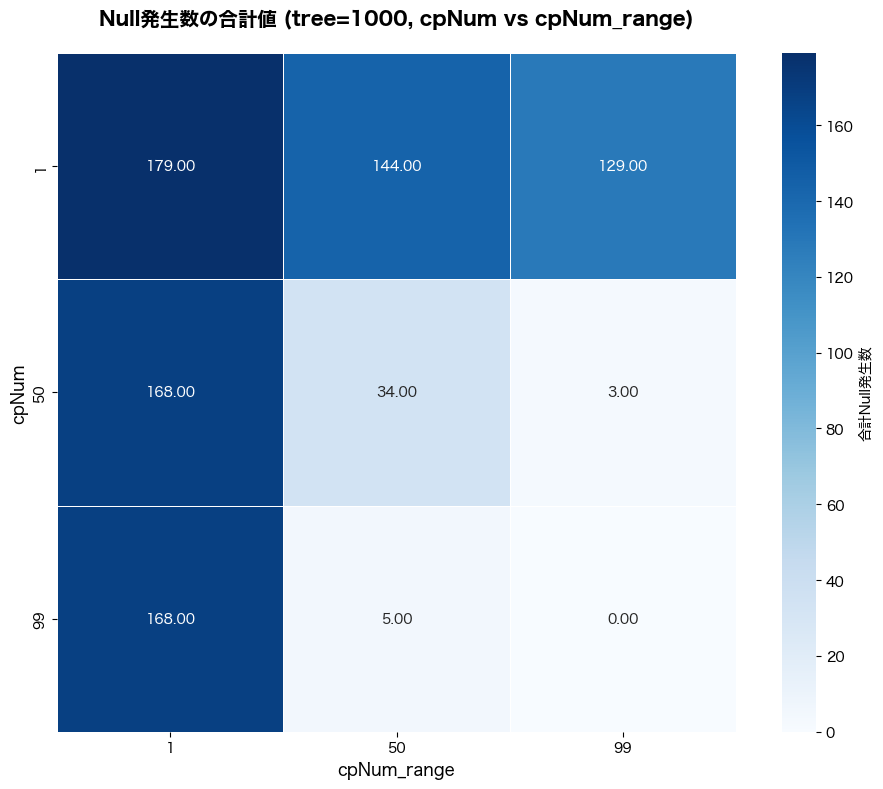

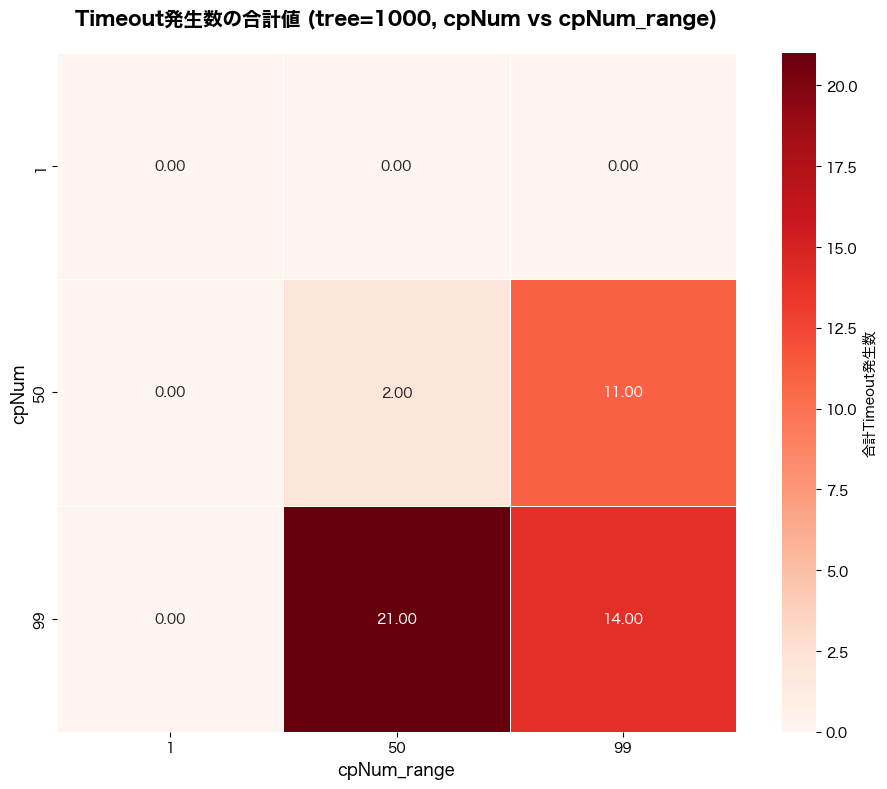


=== 統計的サマリー ===

=== tree=0 の統計情報 ===

tree=0 の総実験数: 360
tree=0 の総バグ発見数: 875
tree=0 の総Null発生数: 843
tree=0 の総Timeout発生数: 82
tree=0 の平均バグ発見率: 2.431
tree=0 の平均Null発生率: 2.342
tree=0 の平均Timeout発生率: 0.228

--- tree=0: cpNum別統計 ---
  cpNum=1: 平均バグ発見数=1.017, 合計=122, 実験数=120
  cpNum=50: 平均バグ発見数=3.092, 合計=371, 実験数=120
  cpNum=99: 平均バグ発見数=3.183, 合計=382, 実験数=120

--- tree=0: cpNum_range別統計 ---
  cpNum_range=1: 平均バグ発見数=0.942, 合計=113, 実験数=120
  cpNum_range=50: 平均バグ発見数=2.958, 合計=355, 実験数=120
  cpNum_range=99: 平均バグ発見数=3.392, 合計=407, 実験数=120

=== tree=500 の統計情報 ===

tree=500 の総実験数: 360
tree=500 の総バグ発見数: 914
tree=500 の総Null発生数: 833
tree=500 の総Timeout発生数: 53
tree=500 の平均バグ発見率: 2.539
tree=500 の平均Null発生率: 2.314
tree=500 の平均Timeout発生率: 0.147

--- tree=500: cpNum別統計 ---
  cpNum=1: 平均バグ発見数=1.117, 合計=134, 実験数=120
  cpNum=50: 平均バグ発見数=3.225, 合計=387, 実験数=120
  cpNum=99: 平均バグ発見数=3.275, 合計=393, 実験数=120

--- tree=500: cpNum_range別統計 ---
  cpNum_range=1: 平均バグ発見数=0.933, 合計=112, 実験数=120
  cpNum_range=50: 平均バグ発見数=3.142

In [25]:
cpNum_params = [ 1, 50, 99 ]
main(cpNum_params)


# cpNum = [1, 50, 99, 200, 300, 700]の時

データ収集を開始しています...
  tree=0 のディレクトリを処理中...
  tree=0: 720/720 ディレクトリを処理しました
  tree=500 のディレクトリを処理中...
  tree=500: 720/720 ディレクトリを処理しました
  tree=1000 のディレクトリを処理中...
  tree=1000: 720/720 ディレクトリを処理しました
データ収集完了: 合計 2160/2160 ディレクトリを処理しました
ヒートマップ分析を開始しています...

=== tree=0 のヒートマップ分析 ===

--- tree=0: 平均値ヒートマップ ---


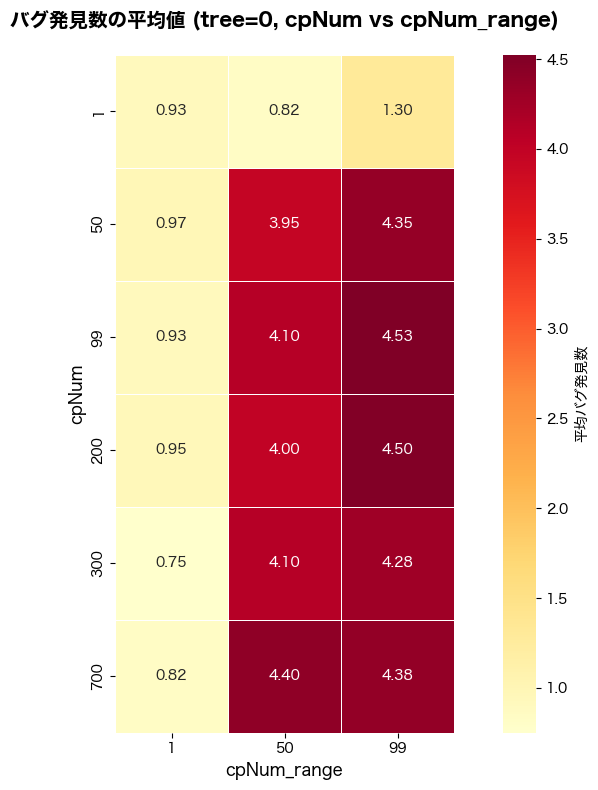

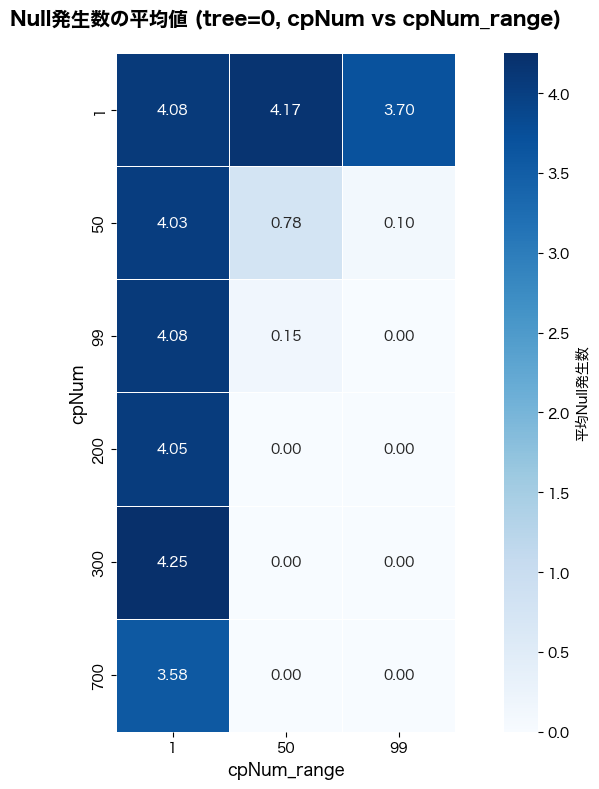

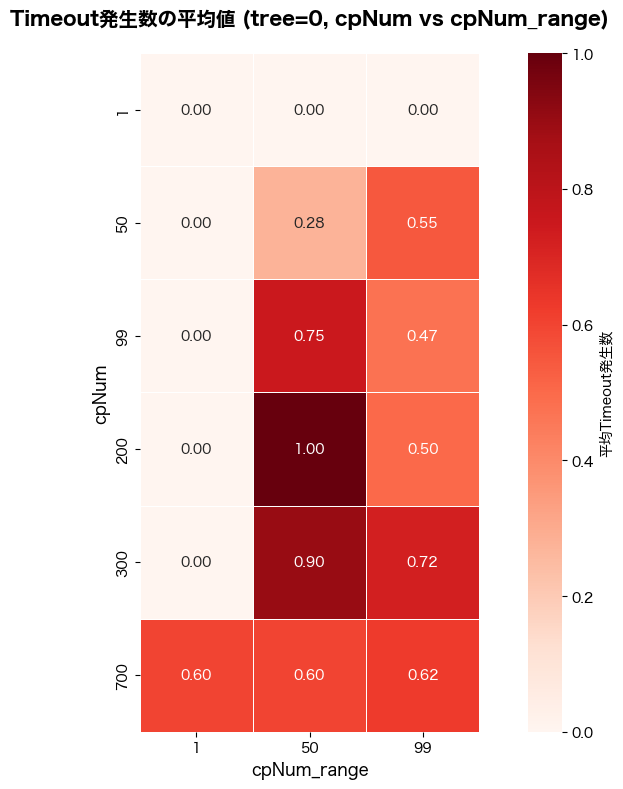


--- tree=0: 合計値ヒートマップ ---


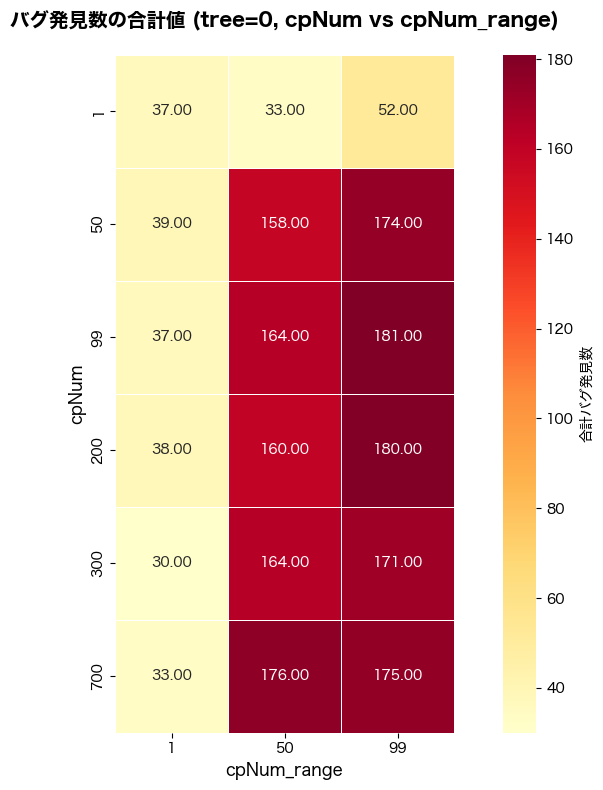

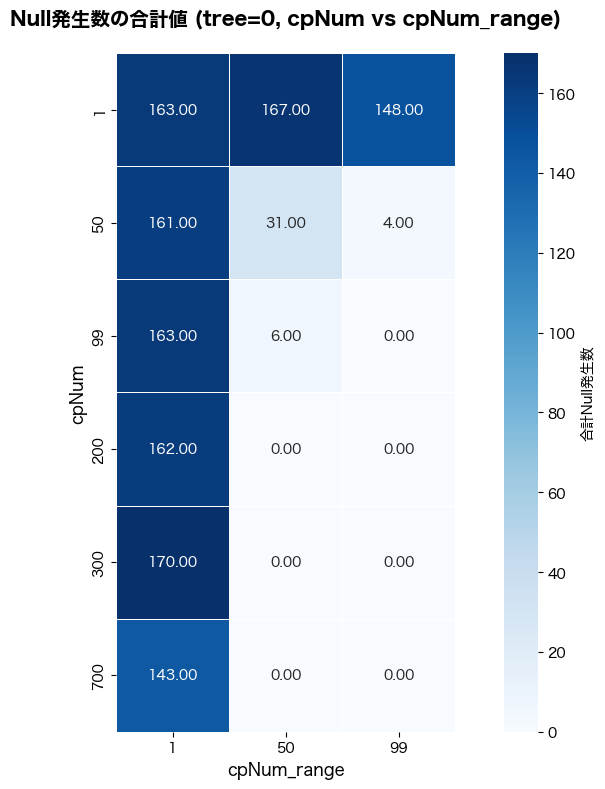

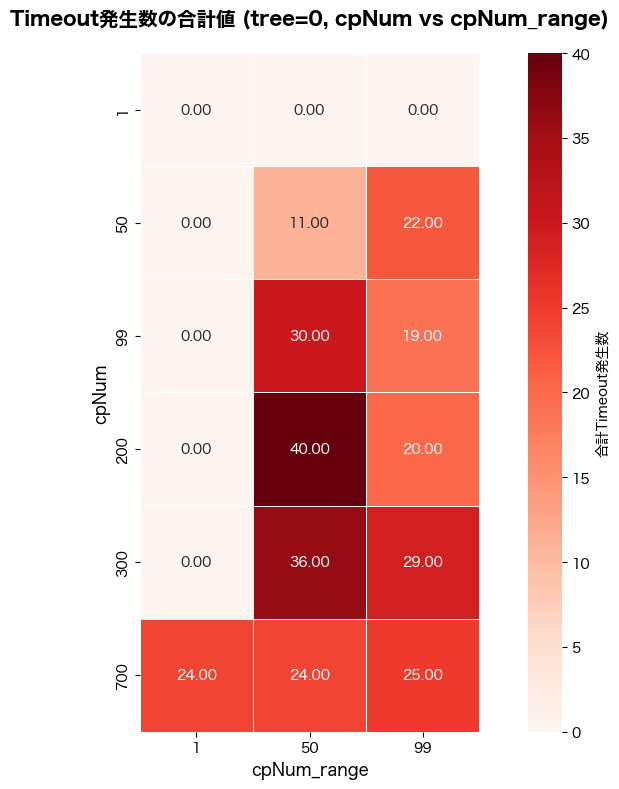


=== tree=500 のヒートマップ分析 ===

--- tree=500: 平均値ヒートマップ ---


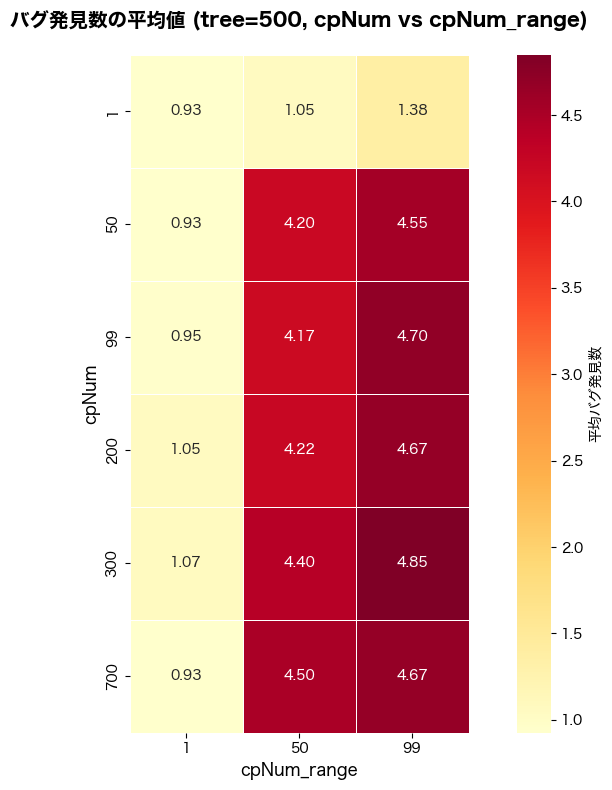

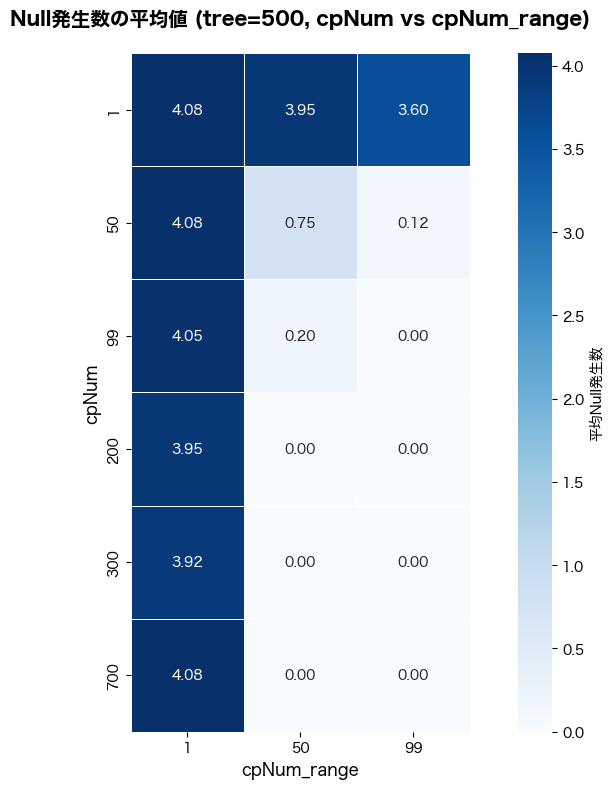

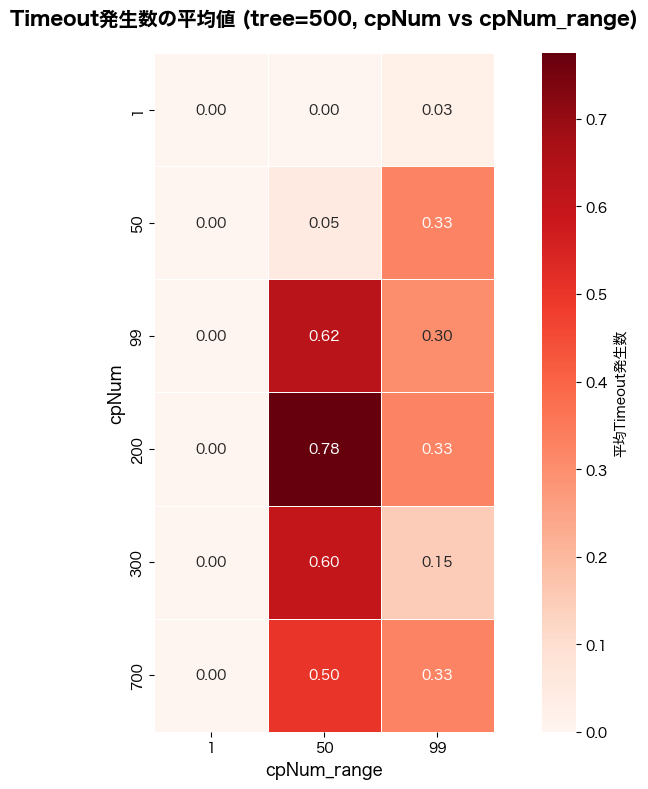


--- tree=500: 合計値ヒートマップ ---


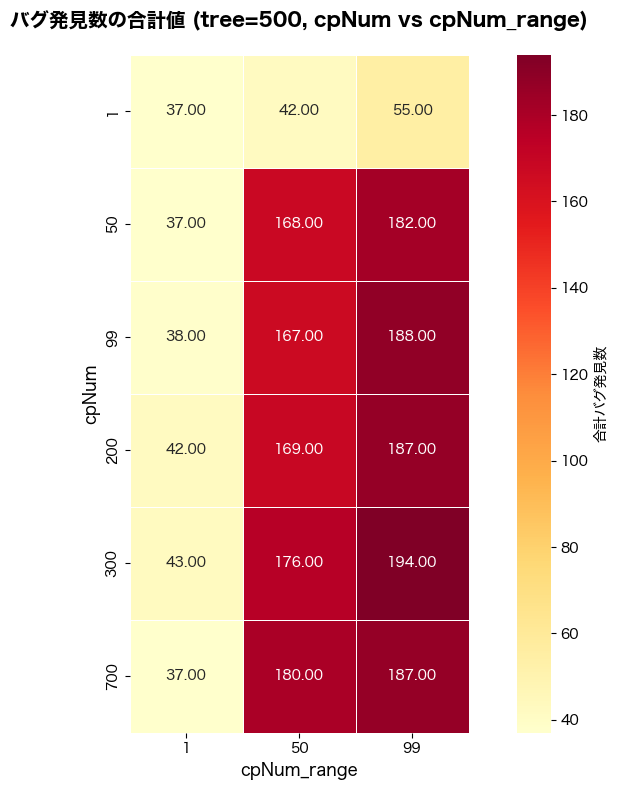

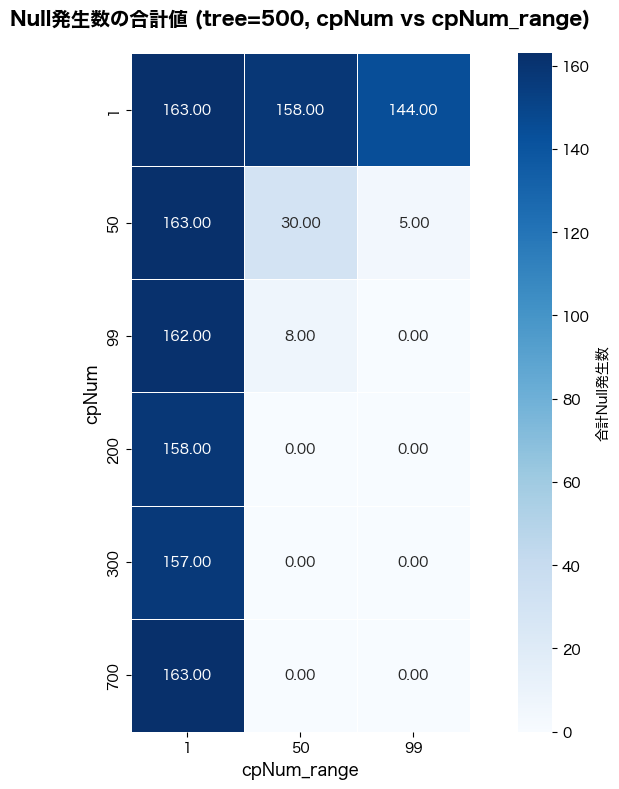

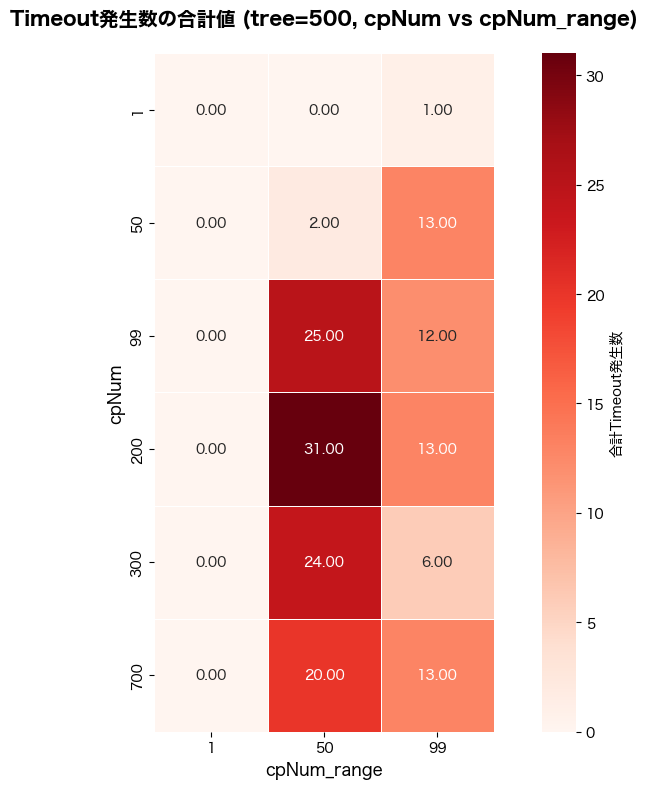


=== tree=1000 のヒートマップ分析 ===

--- tree=1000: 平均値ヒートマップ ---


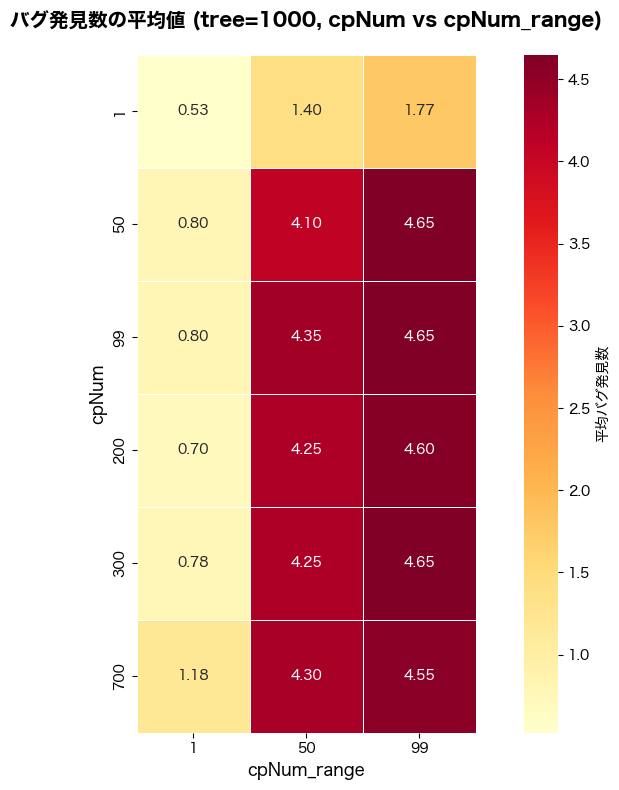

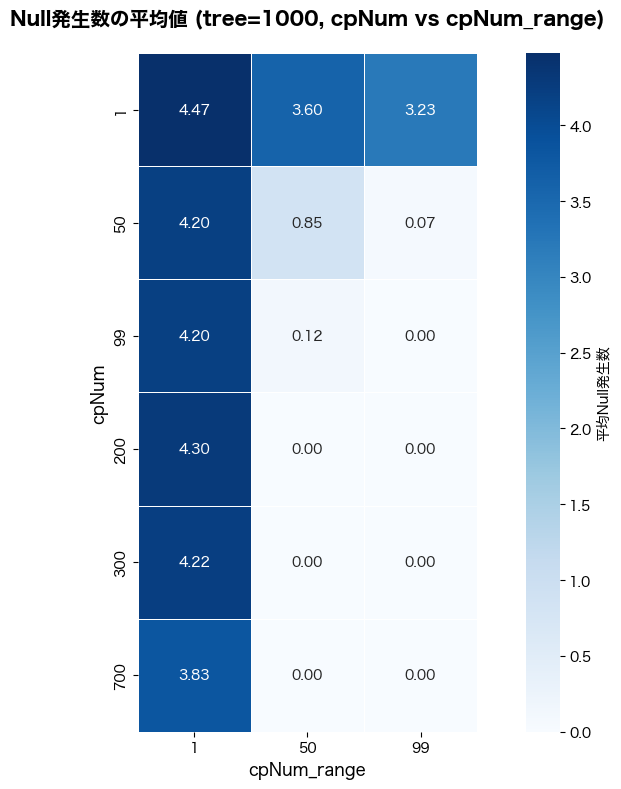

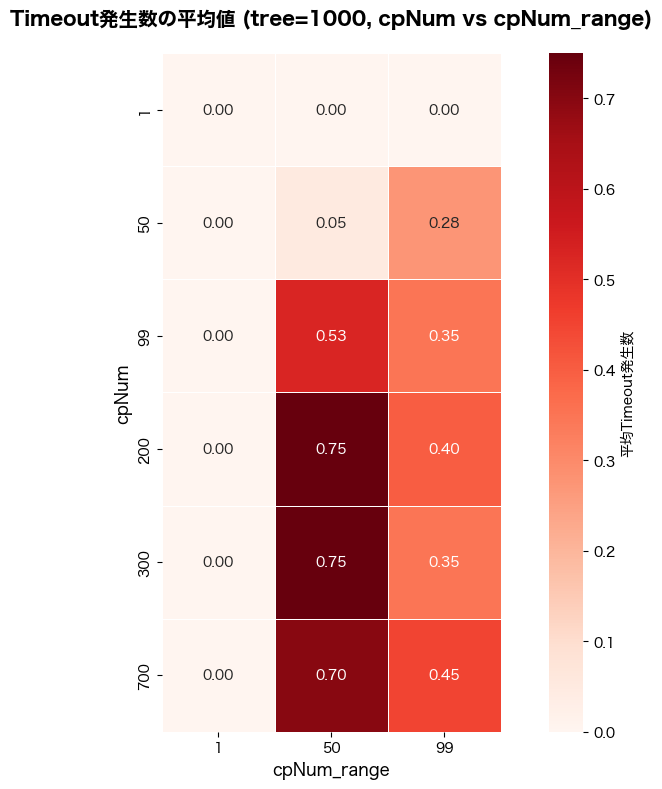


--- tree=1000: 合計値ヒートマップ ---


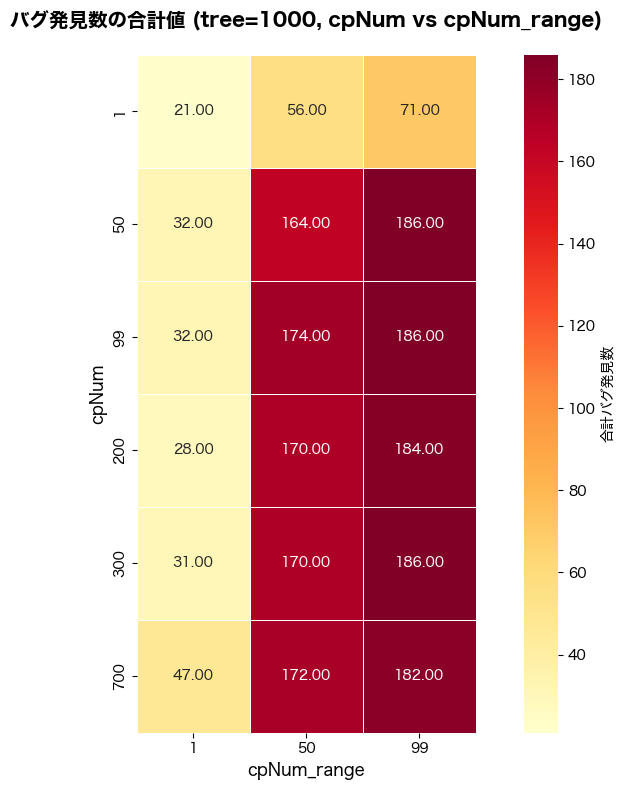

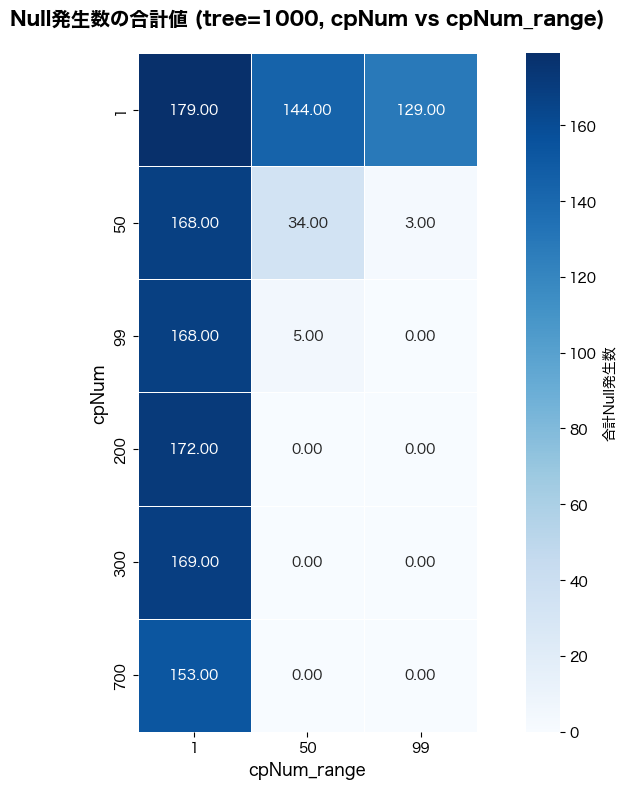

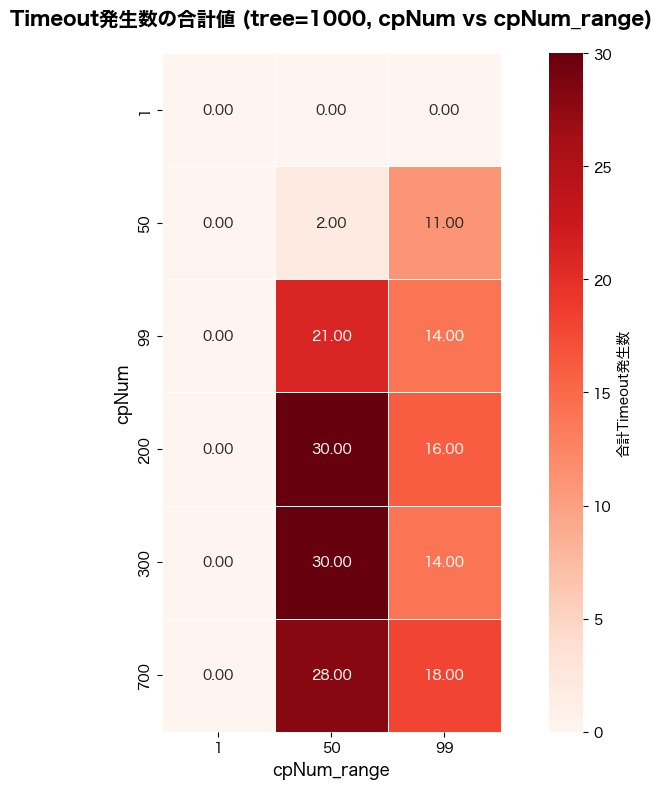


=== 統計的サマリー ===

=== tree=0 の統計情報 ===

tree=0 の総実験数: 720
tree=0 の総バグ発見数: 2002
tree=0 の総Null発生数: 1318
tree=0 の総Timeout発生数: 280
tree=0 の平均バグ発見率: 2.781
tree=0 の平均Null発生率: 1.831
tree=0 の平均Timeout発生率: 0.389

--- tree=0: cpNum別統計 ---
  cpNum=1: 平均バグ発見数=1.017, 合計=122, 実験数=120
  cpNum=50: 平均バグ発見数=3.092, 合計=371, 実験数=120
  cpNum=99: 平均バグ発見数=3.183, 合計=382, 実験数=120
  cpNum=200: 平均バグ発見数=3.150, 合計=378, 実験数=120
  cpNum=300: 平均バグ発見数=3.042, 合計=365, 実験数=120
  cpNum=700: 平均バグ発見数=3.200, 合計=384, 実験数=120

--- tree=0: cpNum_range別統計 ---
  cpNum_range=1: 平均バグ発見数=0.892, 合計=214, 実験数=240
  cpNum_range=50: 平均バグ発見数=3.562, 合計=855, 実験数=240
  cpNum_range=99: 平均バグ発見数=3.888, 合計=933, 実験数=240

=== tree=500 の統計情報 ===

tree=500 の総実験数: 720
tree=500 の総バグ発見数: 2129
tree=500 の総Null発生数: 1311
tree=500 の総Timeout発生数: 160
tree=500 の平均バグ発見率: 2.957
tree=500 の平均Null発生率: 1.821
tree=500 の平均Timeout発生率: 0.222

--- tree=500: cpNum別統計 ---
  cpNum=1: 平均バグ発見数=1.117, 合計=134, 実験数=120
  cpNum=50: 平均バグ発見数=3.225, 合計=387, 実験数=120
  cpNum=99: 平均バグ発見

In [26]:
# cpNumを変えることが多いので先に宣言しておく
cpNum_params = [ 1, 50, 99, 200, 300, 700 ]
main(cpNum_params)

# 単位時間あたりのバグ発見数でヒートマップ

In [27]:
# 拡張版ヒートマップ分析クラス（NULL回数とtimeout回数も含む）

class ExtendedBugRateHeatmapAnalyzer:
    """30分あたりのバグ発見数、NULL回数、timeout回数をヒートマップで分析する拡張クラス（tree値別対応）"""
    
    def __init__(self, cpNum_params):
        """
        初期化
        
        Args:
            cpNum_params (list): cpNumパラメータのリスト
        """
        self.logs_path = 'Logs'
        self.cpnum_values = cpNum_params
        self.cpnum_range_values = [1, 50, 99]
        self.cpnum_dir_values = [1, 2, 3, 4]
        self.checkpoints = list(range(1, 11))
        self.tree_values = [0, 500, 1000]
        
        # tree値別のデータを格納
        self.bugs_rate_data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
        self.nulls_rate_data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
        self.timeouts_rate_data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
        self.parsed_data = []
        
    def parse_directory_name(self, dir_name):
        """ディレクトリ名をパースしてcpNumとcpNum_rangeを抽出"""
        params = dir_name.split(',')
        if len(params) < 30:
            return None, None
            
        try:
            cpnum = None
            cpnum_range = None
            
            for i in range(10):
                if int(params[i]) != 0:
                    cpnum = int(params[i])
                    break
                    
            for i in range(10, 20):
                if int(params[i]) != 0:
                    cpnum_range = int(params[i])
                    break
            
            return cpnum, cpnum_range
        except (ValueError, IndexError):
            return None, None
    
    def load_detected_bugs_data(self, file_path):
        """detected_bugs.csvファイルからデータを読み込み"""
        bug_count = 0
        null_count = 0
        timeout_count = 0
        
        try:
            with open(file_path, 'r', encoding='utf-8') as csvfile:
                reader = csv.reader(csvfile)
                for row in reader:
                    if row == ["null"]:
                        null_count += 1
                    elif row == ["timeout"]:
                        timeout_count += 1
                    elif row:
                        bug_count += 1
        except FileNotFoundError:
            return None
        except Exception as e:
            return None
            
        return {
            'bugs': bug_count,
            'null': null_count,
            'timeout': timeout_count
        }
    
    def collect_data(self):
        """全てのログディレクトリからデータを収集（tree値別）"""
        print("データ収集を開始しています...")
        
        if not os.path.exists(self.logs_path):
            raise FileNotFoundError(f"ログディレクトリが見つかりません: {self.logs_path}")
        
        total_processed = 0
        total_directories = 0
        
        # 各tree値に対して処理
        for tree in self.tree_values:
            tree_path = os.path.join(self.logs_path, f"tree={tree}")
            
            if not os.path.exists(tree_path):
                print(f"警告: {tree_path} が見つかりません。スキップします。")
                continue
            
            print(f"  tree={tree} のディレクトリを処理中...")
            processed_count = 0
            directories_in_tree = len([d for d in os.listdir(tree_path) 
                                     if os.path.isdir(os.path.join(tree_path, d))])
            total_directories += directories_in_tree
            
            for dir_name in os.listdir(tree_path):
                dir_path = os.path.join(tree_path, dir_name)
                
                if not os.path.isdir(dir_path):
                    continue
                    
                # ディレクトリ名をパース
                cpnum, cpnum_range = self.parse_directory_name(dir_name)
                if cpnum is None or cpnum_range is None:
                    continue
                    
                # detected_bugs.csvファイルのパス
                csv_path = os.path.join(dir_path, 'detected_bugs.csv')
                
                # データ読み込み
                data = self.load_detected_bugs_data(csv_path)
                if data is None:
                    continue
                
                # exe_time.csvから実行時間を取得(実行フレーム数)
                exe_time_path = os.path.join(dir_path, 'exe_time.csv')
                total_time = 0
                try:
                    with open(exe_time_path, 'r') as f:
                        total_time = 0
                        for line in f:
                            total_time += int(line)
                except:
                    pass
                
                # 30分あたりの値を計算
                if total_time > 0:
                    bugs_per_30min = (data['bugs'] / total_time) * 60 * 60 * 30
                    nulls_per_30min = (data['null'] / total_time) * 60 * 60 * 30
                    timeouts_per_30min = (data['timeout'] / total_time) * 60 * 60 * 30
                else:
                    bugs_per_30min = 0
                    nulls_per_30min = 0
                    timeouts_per_30min = 0
                
                # データを格納（tree値別に保存）
                self.bugs_rate_data[tree][cpnum][cpnum_range].append(bugs_per_30min)
                self.nulls_rate_data[tree][cpnum][cpnum_range].append(nulls_per_30min)
                self.timeouts_rate_data[tree][cpnum][cpnum_range].append(timeouts_per_30min)
                
                self.parsed_data.append({
                    'tree': tree,
                    'cpnum': cpnum,
                    'cpnum_range': cpnum_range,
                    'bugs_per_30min': bugs_per_30min,
                    'nulls_per_30min': nulls_per_30min,
                    'timeouts_per_30min': timeouts_per_30min,
                    'bug_count': data['bugs'],
                    'null_count': data['null'],
                    'timeout_count': data['timeout'],
                    'total_time': total_time
                })
                
                processed_count += 1
                total_processed += 1
            
            print(f"  tree={tree}: {processed_count}/{directories_in_tree} ディレクトリを処理しました")
            
        print(f"データ収集完了: 合計 {total_processed}/{total_directories} ディレクトリを処理しました")
    
    def create_heatmap_matrix(self, data_dict, tree, aggregation_func=np.mean):
        """ヒートマップ用の行列を作成"""
        matrix = np.zeros((len(self.cpnum_values), len(self.cpnum_range_values)))
        
        for i, cpnum in enumerate(self.cpnum_values):
            for j, cpnum_range in enumerate(self.cpnum_range_values):
                if (tree in data_dict and 
                    cpnum in data_dict[tree] and 
                    cpnum_range in data_dict[tree][cpnum]):
                    values = data_dict[tree][cpnum][cpnum_range]
                    if values:
                        matrix[i, j] = aggregation_func(values)
                    else:
                        matrix[i, j] = np.nan
                else:
                    matrix[i, j] = np.nan
                    
        return matrix
    
    def create_heatmap(self, heatmap_data, title, filename, data_type="30分あたりの回数", cmap='YlOrRd'):
        """
        ヒートマップを作成して表示・保存
        
        Args:
            heatmap_data (pandas.DataFrame): ヒートマップ用データ
            title (str): グラフタイトル
            filename (str): 保存ファイル名
            data_type (str): データタイプ（表示用）
            cmap (str): カラーマップ
        """
        plt.figure(figsize=(12, 8))
        
        # ヒートマップ作成
        sns.heatmap(
            heatmap_data,
            annot=True,
            fmt='.2f',
            cmap=cmap,
            cbar_kws={'label': data_type},
            linewidths=0.5,
            square=True
        )
        
        plt.title(title, fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('cpNum_range', fontsize=14)
        plt.ylabel('cpNum', fontsize=14)
        plt.tight_layout()
        
        plt.show()
        
        return heatmap_data
    
    def create_comprehensive_analysis(self):
        """
        包括的な分析を実行（バグ、NULL、timeoutの3種類のヒートマップ、tree値別）
        """
        print("拡張版ヒートマップ分析を開始...")
        
        # データ収集
        self.collect_data()
        
        if not self.parsed_data:
            print("エラー: データが収集されていません")
            return
        
        parsed_df = pd.DataFrame(self.parsed_data)
        
        print(f"\n解析対象パラメータ:")
        print(f"- cpNum: {sorted(parsed_df['cpnum'].unique())}")
        print(f"- cpNum_range: {sorted(parsed_df['cpnum_range'].unique())}")
        print(f"- tree値: {sorted(parsed_df['tree'].unique())}")
        
        all_results = {}
        
        # 各tree値に対してヒートマップを生成
        for tree in self.tree_values:
            print(f"\n{'='*60}")
            print(f"=== tree={tree} の拡張版ヒートマップ分析 ===")
            print(f"{'='*60}")
        
            # tree値別のヒートマップを作成
            
            # バグ発見数ヒートマップ
            bugs_matrix = self.create_heatmap_matrix(self.bugs_rate_data, tree, np.mean)
            bugs_df = pd.DataFrame(
                bugs_matrix,
                index=[x for x in self.cpnum_values],
                columns=[x for x in self.cpnum_range_values]
            )
            self.create_heatmap(
                bugs_df,
                f"30分あたりのバグ発見数 (tree={tree}, cpNum vs cpNum_range)",
                f"tree{tree}_bugs_heatmap_30min.png",
                "30分あたりのバグ発見数",
                'YlOrRd'
            )
            
            # NULL回数ヒートマップ
            nulls_matrix = self.create_heatmap_matrix(self.nulls_rate_data, tree, np.mean)
            nulls_df = pd.DataFrame(
                nulls_matrix,
                index=[x for x in self.cpnum_values],
                columns=[x for x in self.cpnum_range_values]
            )
            self.create_heatmap(
                nulls_df,
                f"30分あたりのNULL回数 (tree={tree}, cpNum vs cpNum_range)",
                f"tree{tree}_nulls_heatmap_30min.png",
                "30分あたりのNULL回数",
                'Blues'
            )
            
            # timeout回数ヒートマップ
            timeouts_matrix = self.create_heatmap_matrix(self.timeouts_rate_data, tree, np.mean)
            timeouts_df = pd.DataFrame(
                timeouts_matrix,
                index=[x for x in self.cpnum_values],
                columns=[x for x in self.cpnum_range_values]
            )
            self.create_heatmap(
                timeouts_df,
                f"30分あたりのtimeout回数 (tree={tree}, cpNum vs cpNum_range)",
                f"tree{tree}_timeouts_heatmap_30min.png",
                "30分あたりのtimeout回数",
                'Reds'
            )
            
            # tree値別の統計情報を表示
            tree_df = parsed_df[parsed_df['tree'] == tree]
            if len(tree_df) > 0:
                print(f"\ntree={tree} の統計情報:")
                print(f"- 総パラメータセット数: {len(tree_df)}")
                print(f"- 平均30分あたりバグ発見数: {tree_df['bugs_per_30min'].mean():.3f}")
                print(f"- 平均30分あたりNULL回数: {tree_df['nulls_per_30min'].mean():.3f}")
                print(f"- 平均30分あたりtimeout回数: {tree_df['timeouts_per_30min'].mean():.3f}")
            
            all_results[tree] = {
                'bugs': bugs_df,
                'nulls': nulls_df,
                'timeouts': timeouts_df
            }
        
        # 全体の統計サマリー
        print("\n=== 全体統計サマリー ===")
        print(f"総パラメータセット数: {len(parsed_df)}")
        print(f"平均30分あたりバグ発見数: {parsed_df['bugs_per_30min'].mean():.3f}")
        print(f"平均30分あたりNULL回数: {parsed_df['nulls_per_30min'].mean():.3f}")
        print(f"平均30分あたりtimeout回数: {parsed_df['timeouts_per_30min'].mean():.3f}")
        
        # tree値別の統計
        print("\n--- tree値別統計 ---")
        for tree in sorted(parsed_df['tree'].unique()):
            tree_df = parsed_df[parsed_df['tree'] == tree]
            print(f"\ntree={tree}:")
            print(f"  平均30分あたりバグ発見数={tree_df['bugs_per_30min'].mean():.3f}")
            print(f"  平均30分あたりNULL回数={tree_df['nulls_per_30min'].mean():.3f}")
            print(f"  平均30分あたりtimeout回数={tree_df['timeouts_per_30min'].mean():.3f}")
        
        print(f"\n分析完了！tree値別のヒートマップが保存されました")
        
        return all_results


拡張版ヒートマップ分析を開始...
データ収集を開始しています...
  tree=0 のディレクトリを処理中...
  tree=0: 720/720 ディレクトリを処理しました
  tree=500 のディレクトリを処理中...
  tree=500: 720/720 ディレクトリを処理しました
  tree=1000 のディレクトリを処理中...
  tree=1000: 720/720 ディレクトリを処理しました
データ収集完了: 合計 2160/2160 ディレクトリを処理しました

解析対象パラメータ:
- cpNum: [np.int64(1), np.int64(50), np.int64(99), np.int64(200), np.int64(300), np.int64(700)]
- cpNum_range: [np.int64(1), np.int64(50), np.int64(99)]
- tree値: [np.int64(0), np.int64(500), np.int64(1000)]

=== tree=0 の拡張版ヒートマップ分析 ===


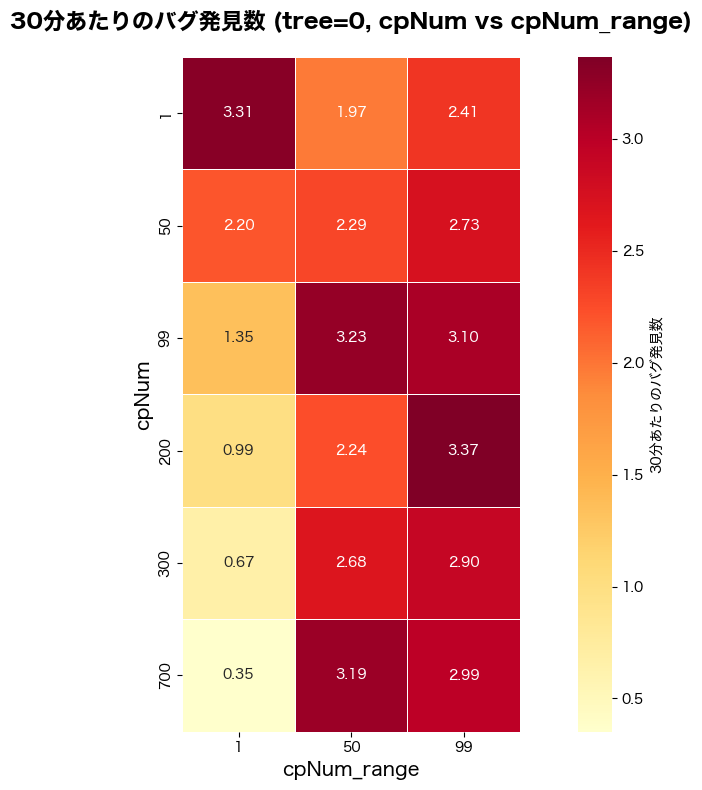

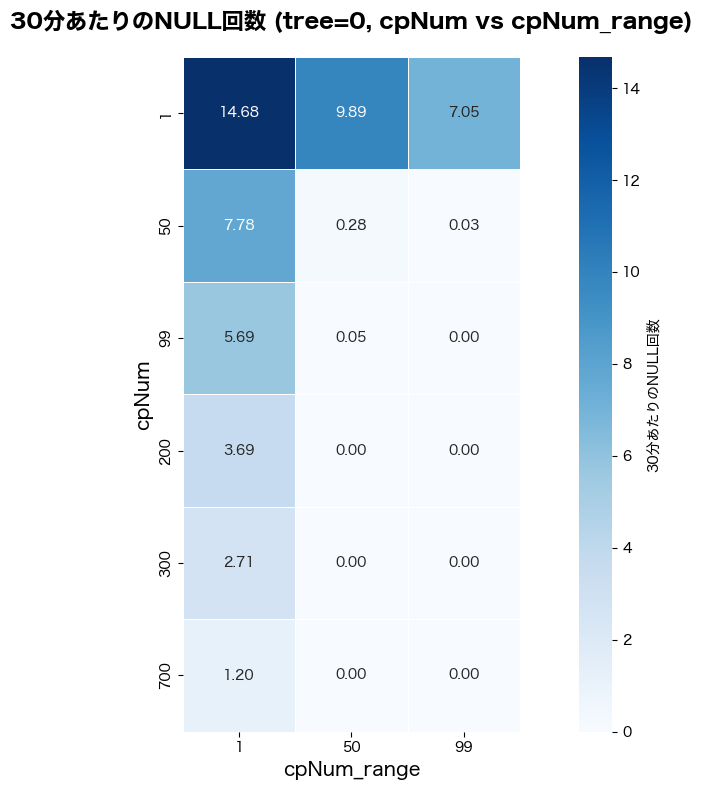

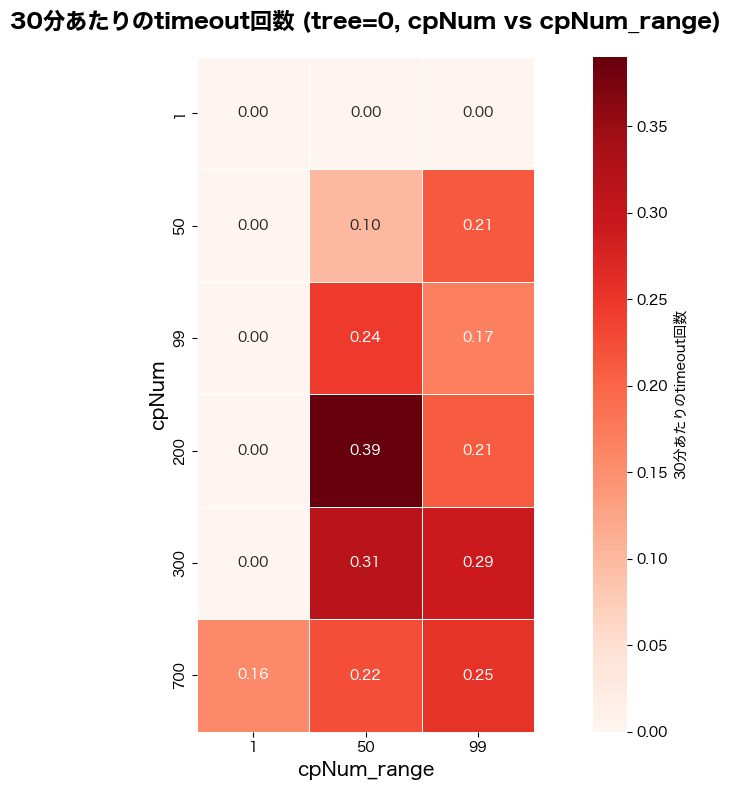


tree=0 の統計情報:
- 総パラメータセット数: 720
- 平均30分あたりバグ発見数: 2.333
- 平均30分あたりNULL回数: 2.947
- 平均30分あたりtimeout回数: 0.143

=== tree=500 の拡張版ヒートマップ分析 ===


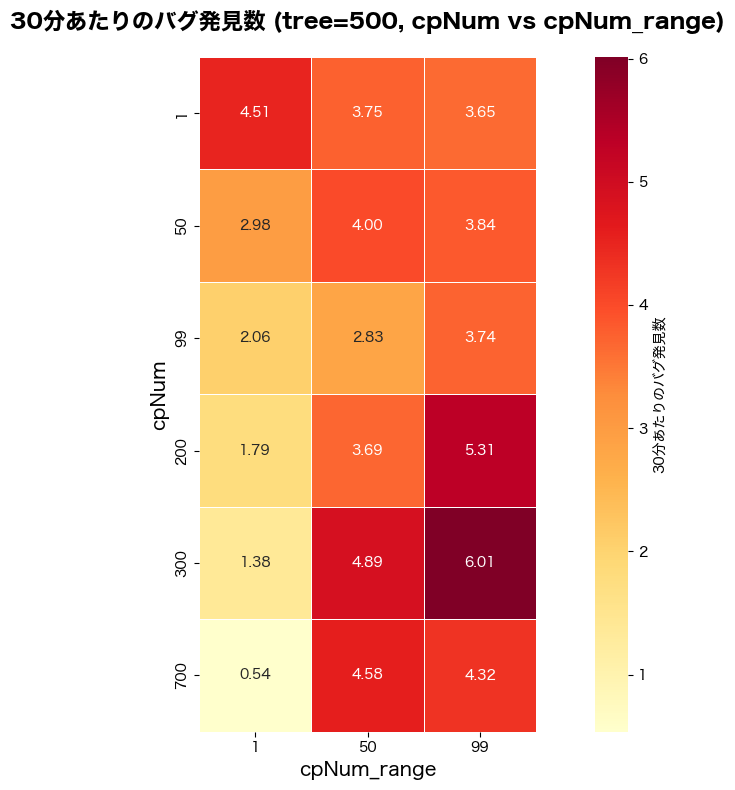

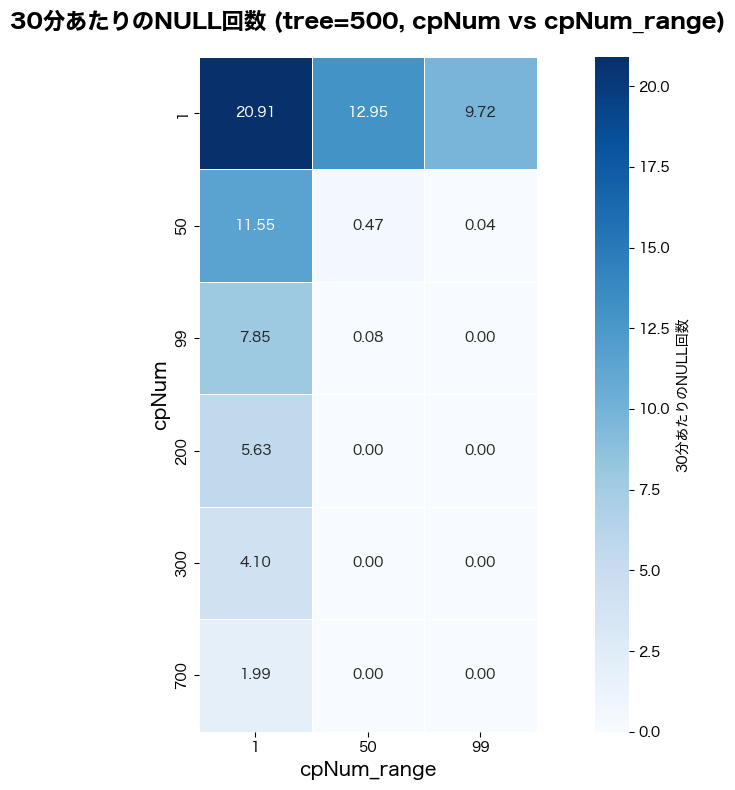

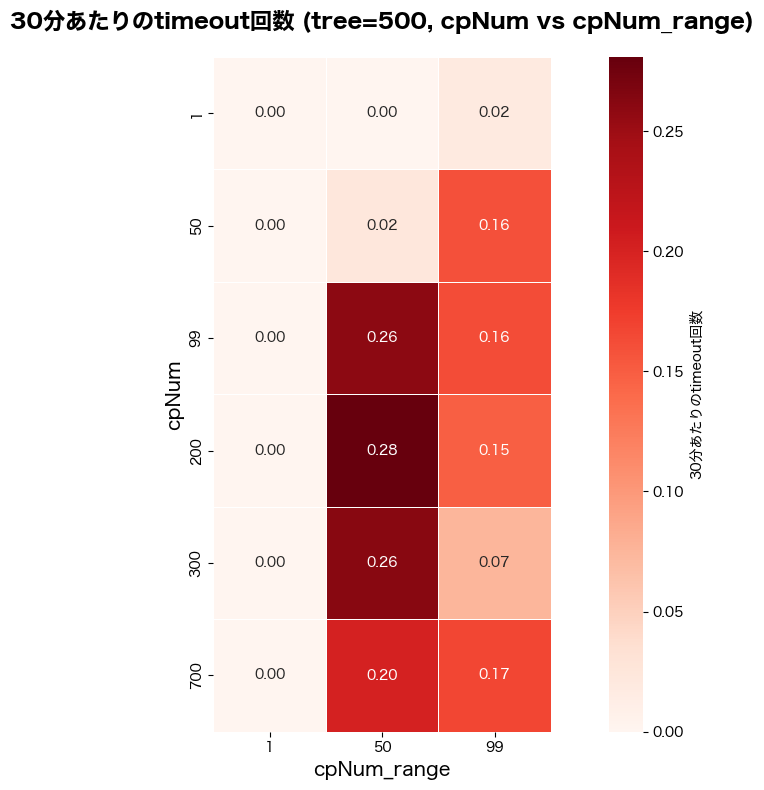


tree=500 の統計情報:
- 総パラメータセット数: 720
- 平均30分あたりバグ発見数: 3.548
- 平均30分あたりNULL回数: 4.183
- 平均30分あたりtimeout回数: 0.098

=== tree=1000 の拡張版ヒートマップ分析 ===


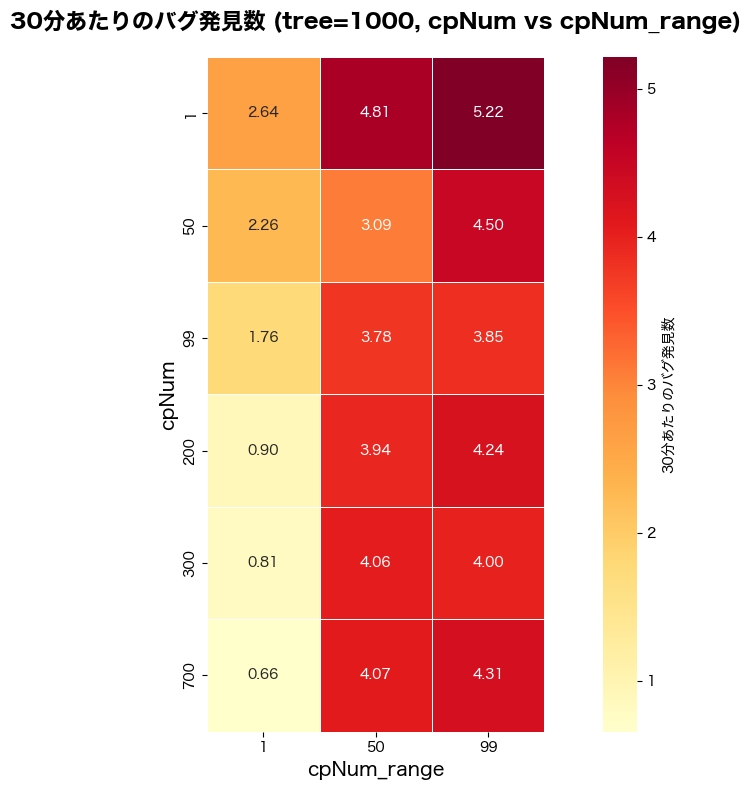

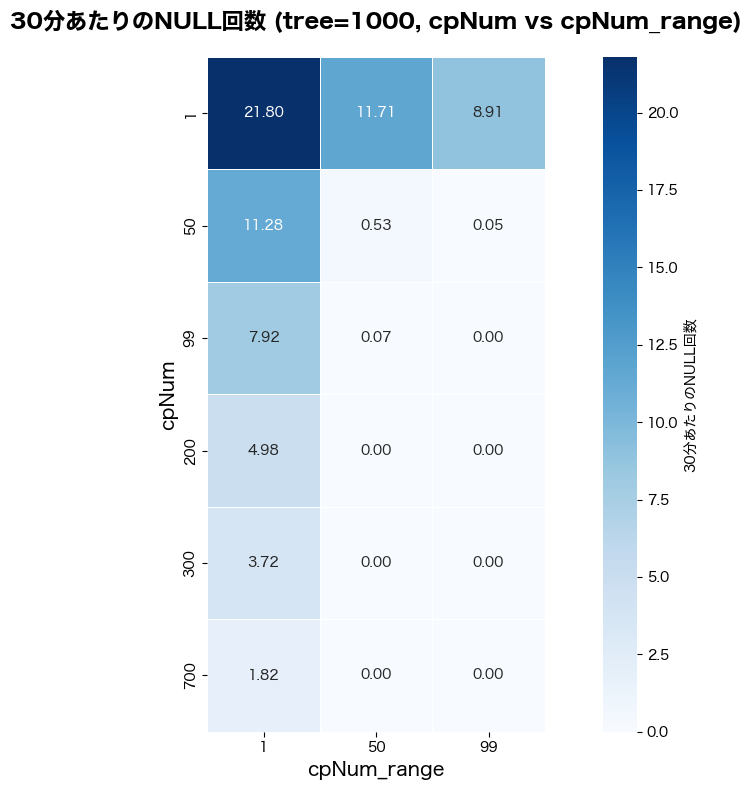

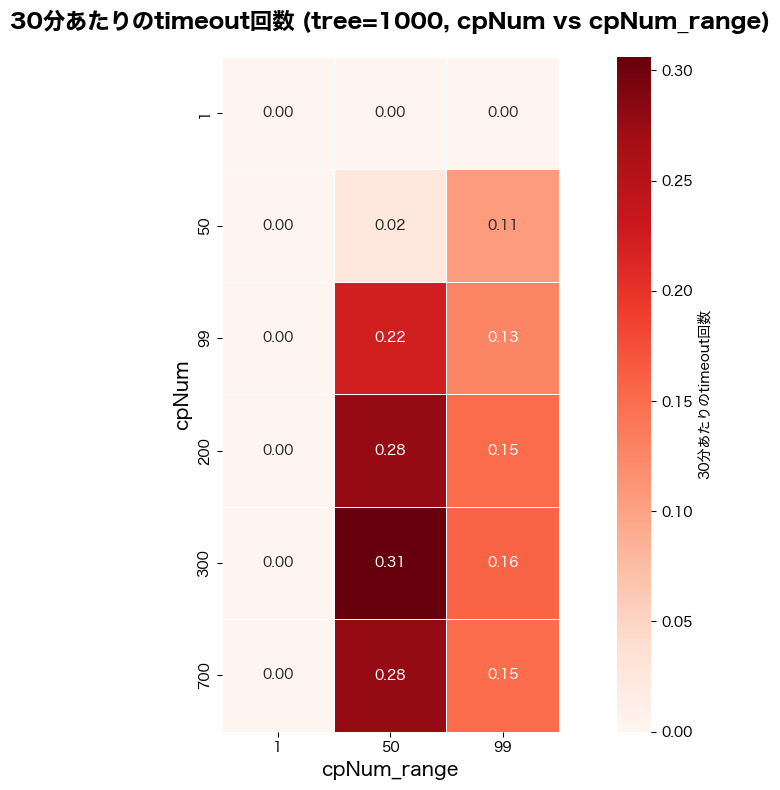


tree=1000 の統計情報:
- 総パラメータセット数: 720
- 平均30分あたりバグ発見数: 3.272
- 平均30分あたりNULL回数: 4.044
- 平均30分あたりtimeout回数: 0.100

=== 全体統計サマリー ===
総パラメータセット数: 2160
平均30分あたりバグ発見数: 3.051
平均30分あたりNULL回数: 3.725
平均30分あたりtimeout回数: 0.113

--- tree値別統計 ---

tree=0:
  平均30分あたりバグ発見数=2.333
  平均30分あたりNULL回数=2.947
  平均30分あたりtimeout回数=0.143

tree=500:
  平均30分あたりバグ発見数=3.548
  平均30分あたりNULL回数=4.183
  平均30分あたりtimeout回数=0.098

tree=1000:
  平均30分あたりバグ発見数=3.272
  平均30分あたりNULL回数=4.044
  平均30分あたりtimeout回数=0.100

分析完了！tree値別のヒートマップが保存されました


In [28]:
# 拡張版ヒートマップ分析を実行

# cpNumパラメータを設定
cpNum_params = [1, 50, 99, 200, 300, 700]

# 拡張版分析クラスのインスタンスを作成
extended_analyzer = ExtendedBugRateHeatmapAnalyzer(cpNum_params)

# 包括的な分析を実行（バグ、NULL、timeoutの3種類のヒートマップ、tree値別）
all_results = extended_analyzer.create_comprehensive_analysis()
